In [1]:
%matplotlib agg
import yaml
import pyaml
import functools
from pathlib import Path
from collections import defaultdict

import tqdm
import torch
import numpy as np
import pandas as pd
import torchgraphs as tg
import scipy.spatial.distance
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from pandas import IndexSlice as ix

import proteins.utils
import proteins.dataset
import proteins.features

Functions to invert RBF and backpropagate RBF gradient to Distance gradient

In [2]:
def rbf(x, sigma):
    """y = exp(- x^2 / (2 sigma))"""
    return np.exp(- x ** 2 / (2 * sigma))

def rbf_grad(x, sigma):
    """dy / dx = - x exp(- x^2/(2 sigma)) / sigma"""
    return - x * np.exp(- x**2 / (2 * sigma)) / sigma

def rbf_inv(y, sigma):
    """x = sqrt(- 2 sigma log(y))"""
    return np.sqrt(- 2 * sigma * np.log(y))

def rbf_inv_grad(y, sigma):
    """dx / dy = sigma / (y * sqrt(-2 sigma log(y)))"""
    return sigma / (y * np.sqrt(- 2 * sigma * np.log(y)))
# Not really useful here
del rbf_inv_grad

def sparse_to_dense(values, senders, receivers, num_nodes):
    out = np.full((num_nodes, num_nodes), np.nan)
    for i, j, v in zip(senders, receivers, values):
        out[i,j] = v
    return out

def grad_magnitude_dense(graph, sigma):
    """Computes the grad magnitude matrix (dense symmetric)"""
    # Sum gradient of edge i->j and j->i
    grad_edges = (graph.edge_features.grad[graph.num_edges // 2:] + graph.edge_features.grad[:graph.num_edges // 2])
    return sparse_to_dense(grad_edges.norm(dim=1).repeat(2), graph.senders, graph.receivers, graph.num_nodes)

def dist_dense(graph, sigma):
    """Computes the distance matrix (dense symmetric)"""
    dist_rbf = graph.edge_features[:, 0].detach().cpu().numpy()
    dist = rbf_inv(dist_rbf, sigma)
    return sparse_to_dense(dist, graph.senders, graph.receivers, graph.num_nodes)

def grad_dist_dense(graph, sigma):
    """Computes the grad distance matrix (dense symmetric)"""
    dist_rbf = graph.edge_features[:, 0].detach().cpu().numpy()
    dist = rbf_inv(dist_rbf, sigma)
    
    # d score / d rbf
    grad_dist_rbf = graph.edge_features.grad[:, 0].cpu().numpy()
    # d score / d dist = (d score / d rbf) * (d rbf / d dist)
    grad_dist = grad_dist_rbf * rbf_grad(dist, sigma)
    
    # Sum gradient of edge i->j and j->i
    grad_dist = grad_dist[:graph.num_edges // 2] + grad_dist[graph.num_edges // 2:]
    return sparse_to_dense(np.tile(grad_dist, 2), graph.senders, graph.receivers, graph.num_nodes)

def cosine_similarity(grad_dist, grad_dist_manual):
    valid = np.isfinite(grad_dist_manual) & np.isfinite(grad_dist)
    return 1 - scipy.spatial.distance.cosine(
        grad_dist[valid],
        grad_dist_manual[valid]
    )

## Model and data parameters

In [3]:
run_path = Path('../runs/l6_128-512-512_16-64-32_dr.2_bnno_lr.001_wd.00001_llw5_llbno_co8_si15_seyes_eb0_es0_dreamy_pare')
with run_path.joinpath('experiment.latest.yaml').open() as f:
    ex = yaml.safe_load(f)
print(pyaml.dump({'model': ex['model'], 'data': ex['data'], 'misc': ex['history'][-1]['misc']}, sort_dicts=False))

model:
  fn: proteins.networks.ProteinGN
  layers: 6
  mp_in_edges: 128
  mp_in_nodes: 512
  mp_in_globals: 512
  mp_out_edges: 16
  mp_out_nodes: 64
  mp_out_globals: 32
  dropout: 0.2
  batch_norm: false
  enc_in_nodes: 83
  enc_in_edges: 8
data:
  cutoff: 8
  sigma: 15
  separation: true
  encoding_size: 0
  encoding_base: 0
misc:
  parameters: 1448035
  samples:
    train: 106365
    val: 9215



## Model

In [4]:
device = 'cuda'
net = proteins.utils.import_(ex['model']['fn'])(**{k: v for k, v in ex['model'].items() if k != 'fn'})
net.load_state_dict(torch.load(run_path / 'model.latest.pt', map_location=device))
net.to(device)
net.eval();

## Local predictions for a all decoys of a single target

In [5]:
casp, target = 'CASP11', 'T0773'

The network was trained with a certain cutoff (many edges removed), but we can actually evaluate with all edges (cutoff 12).
Performance is lower, because the first layers are not used to "seeing" so many neighbors, but when doing explanations we get gradients for more edges.

In [6]:
cutoff = ex['data']['cutoff']
#cutoff = 12 - 1e-10

In [7]:
with open(f'../data/{casp}/dataset_stats.yaml') as f:
    max_sequence_length = yaml.safe_load(f)['max_length']

transforms = [
    # Edge features (removing edges should go first)
    proteins.dataset.RemoveEdges(cutoff=cutoff),
    proteins.dataset.RbfDistEdges(sigma=ex['data']['sigma']),
    proteins.dataset.SeparationEncoding(use_separation=ex['data']['separation']),
    
    # Node features (selecting features should go first)
    proteins.dataset.SelectNodeFeatures(ex['data'].get('residues', True), ex['data'].get('partial_entropy', True),
                       ex['data'].get('self_info', True), ex['data'].get('dssp_features', True)),
    proteins.dataset.PositionalEncoding(encoding_size=ex['data']['encoding_size'], base=ex['data']['encoding_base'],
                       max_sequence_length=max_sequence_length)
]

df = pd.read_csv(f'../data/{casp}/samples.csv').query(f'target == "{target}"')
df.path = [f'../data/{casp}/' + p for p in df['path']]
ds = proteins.dataset.ProteinQualityDataset(df, transforms=transforms)
aminoacids = [proteins.features.Input.Node.AMINOACID_NAMES[r] for r in ds[0][2].node_features[:, proteins.features.Input.Node.RESIDUES].argmax(dim=1)]

lddt_all = {}
dl = torch.utils.data.DataLoader(ds, batch_size=1, collate_fn=tg.data.GraphBatch.collate)
for _, decoy, graph_in, graph_true in iter(dl):
    graph_in = graph_in.to(device).requires_grad_()
    graph_pred = net(graph_in)    
    
    graph_in.zero_grad_()
    net.zero_grad()
    graph_pred.node_features.mean().backward()
    
    lddt_all[(decoy[0], 'pred')] = graph_pred.node_features[:, proteins.features.Output.Node.LOCAL_LDDT].detach().cpu().numpy()
    lddt_all[(decoy[0], 'true')] = graph_true.node_features[:, proteins.features.Output.Node.LOCAL_LDDT].detach().cpu().numpy()
    lddt_all[(decoy[0], 'grad_nodes')] = graph_in.node_features.grad.norm(dim=1).cpu().numpy()
    lddt_all[(decoy[0], 'grad_edges')] = np.sum(np.nan_to_num(grad_magnitude_dense(graph_in, ex['data']['sigma'])), axis=0)


lddt_all = pd.DataFrame(lddt_all, index=pd.RangeIndex(1, graph_in.num_nodes + 1, name='Residue')).rename_axis(columns=['Decoy', 'LDDT'])
lddt_all.to_csv('OutputVisualization-predictions.csv', index=False)

rmse = np.sqrt(np.nanmean((lddt_all.loc[:, ix[:, 'true']].values - lddt_all.loc[:, ix[:, 'pred']].values) ** 2))
print(f'{casp}/{target} ({len(df)} decoys): {rmse:.5f} RMSE')

CASP11/T0773 (199 decoys): 0.16536 RMSE


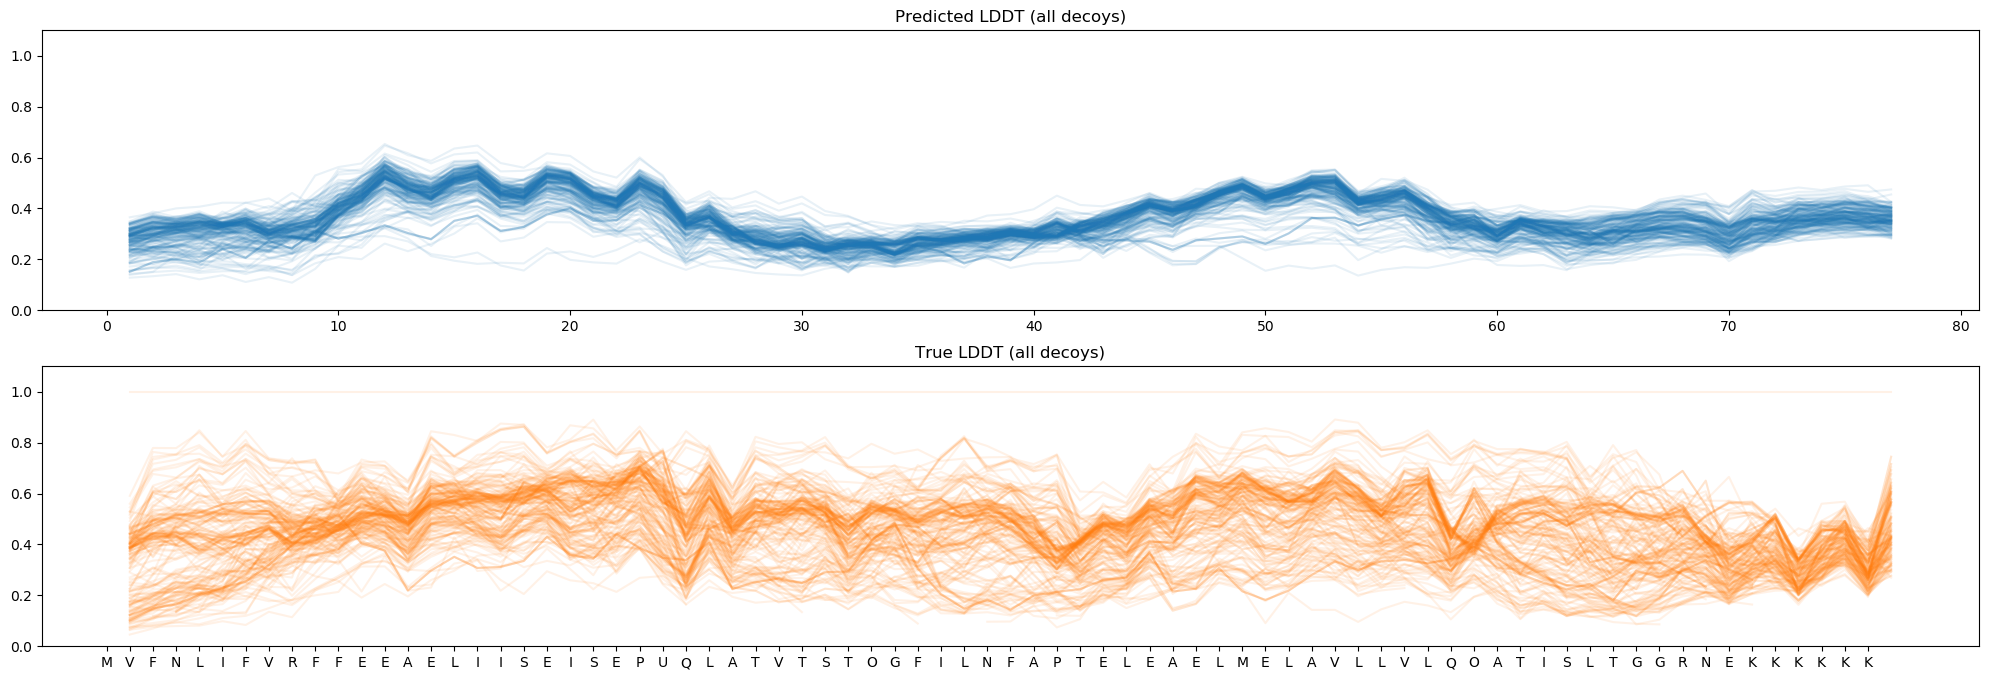

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(25, 8))
for decoy in lddt_all.columns.levels[0]:
    axes[0].plot(lddt_all[(decoy, 'pred')], color='C0', alpha=.1)
    axes[1].plot(lddt_all[(decoy, 'true')], color='C1', alpha=.1)

axes[1].set_xticks(np.arange(len(aminoacids)))
axes[1].set_xticklabels(aminoacids)
axes[0].set_title('Predicted LDDT (all decoys)')
axes[1].set_title('True LDDT (all decoys)')
axes[0].set_ylim(0,1.1)
axes[1].set_ylim(0,1.1)

display(fig)
plt.close(fig);

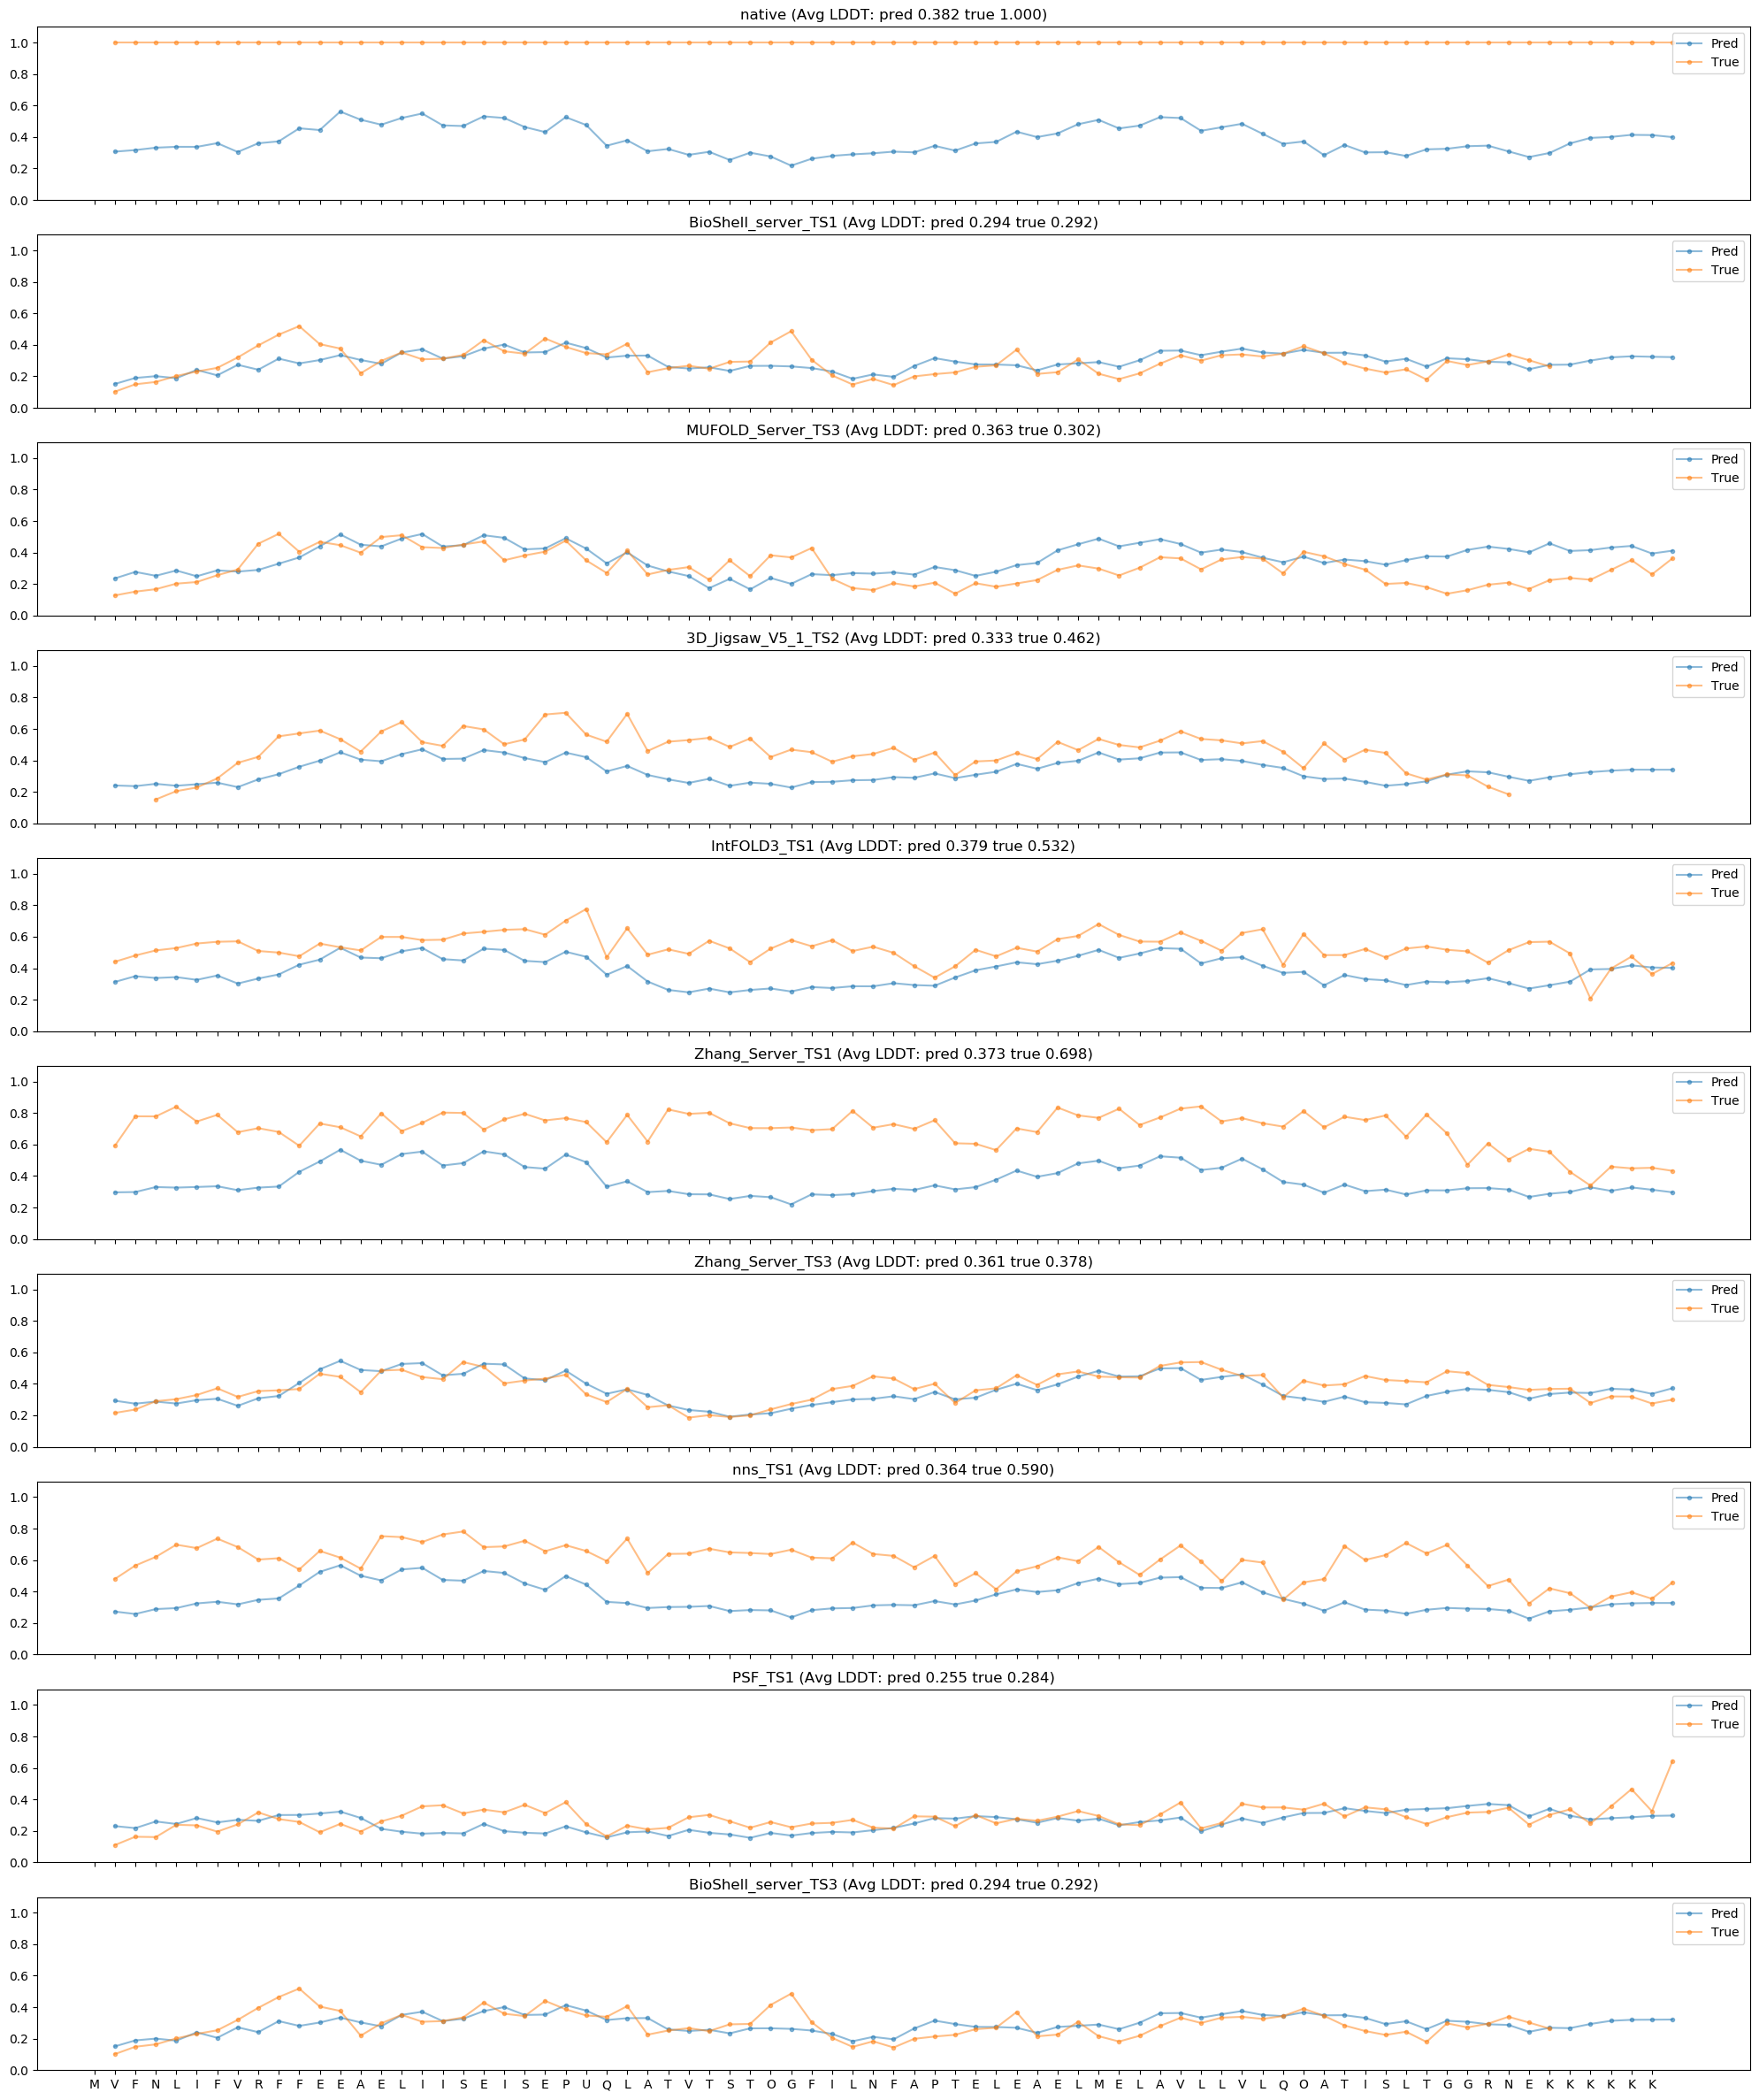

In [9]:
howmany = 10
fig, axes = plt.subplots(howmany, 1, figsize=(25, 3*howmany), sharex=True)
for decoy, ax in zip(df.model, axes.flat):
    ax.plot(lddt_all[(decoy, 'pred')], label='Pred', color='C0', alpha=.5, marker='.', markerfacecolor='C0')
    ax.plot(lddt_all[(decoy, 'true')], label='True', color='C1', alpha=.5, marker='.', markerfacecolor='C1')
    ax.set_ylim(0,1.1)
    ax.set_title(f'{decoy} (Avg LDDT: pred {lddt_all[(decoy, "pred")].mean():.3f} true {np.nanmean(lddt_all[(decoy, "true")]):.3f})')
    ax.legend(loc='upper right')

ax.set_xticks(np.arange(len(aminoacids)))
ax.set_xticklabels(aminoacids)

display(fig)
plt.close(fig);

## Input Gradients
Compute edge and gradient inputs by backpropagating from the output scores.

In [10]:
_, native, graph_native, _ = ds[0]
print('Native:', casp, target, native)

_, decoy, graph_in, graph_true = ds[6]
graph_in = tg.data.GraphBatch.from_graphs([graph_in]).cuda()
graph_in.node_features.requires_grad_()
graph_in.edge_features.requires_grad_()
graph_pred = net(graph_in)
print('Decoy: ', casp, target, decoy)

Native: CASP11 T0773 native
Decoy:  CASP11 T0773 Zhang_Server_TS3


In [11]:
graph_in.zero_grad_()
graph_pred.node_features.mean().backward(retain_graph=True)

In [12]:
def plots_nodes(graph_in, graph_pred, graph_true, highlight_residue=None):
    def highlight_res(ax):
        if highlight_residue is not None:
            ax.axvline(highlight_residue, color='k', linestyle='--', alpha=.5)
    
    fig = plt.figure(figsize=(25, 12))
    gs = plt.GridSpec(2, 2, width_ratios=(50, 1), height_ratios=(1,4), hspace=.05, wspace=.01)

    ax = fig.add_subplot(gs[0, 0])
    ax.bar(np.arange(graph_in.num_nodes), graph_in.node_features.grad.norm(dim=1).cpu().numpy(), color='C3')
    ax.set_ylabel('Gradient Magnitude')
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.tick_params(labelbottom=False)
    highlight_res(ax)

    axt = ax.twinx()
    axt.plot(np.arange(graph_in.num_nodes), graph_true.node_features[:,0].detach().cpu().numpy(), color='C2', label='True')
    axt.plot(np.arange(graph_in.num_nodes), graph_pred.node_features[:,0].detach().cpu().numpy(), color='C1', label='Pred')
    axt.legend()
    axt.set_ylabel('LDDT')

    ax = fig.add_subplot(gs[1, 0], sharex=ax)
    im = ax.imshow(graph_in.node_features.grad.cpu().numpy().transpose(), aspect='auto', cmap='bwr', vmin=-graph_in.node_features.grad.abs().max().item(), vmax=graph_in.node_features.grad.abs().max().item())
    ax.set_ylabel('Node Feature')
    ax.set_yticks([
        (proteins.features.Input.Node.RESIDUES.stop - proteins.features.Input.Node.RESIDUES.start) / 2,
        proteins.features.Input.Node.RESIDUES.stop + (proteins.features.Input.Node.PARTIAL_ENTROPY.stop - proteins.features.Input.Node.PARTIAL_ENTROPY.start) / 2,
        proteins.features.Input.Node.PARTIAL_ENTROPY.stop + (proteins.features.Input.Node.SELF_INFO.stop - proteins.features.Input.Node.SELF_INFO.start) / 2,
        proteins.features.Input.Node.SELF_INFO.stop + (proteins.features.Input.Node.DSSP_FEATURES.stop - proteins.features.Input.Node.DSSP_FEATURES.start) / 2,
    ])
    ax.set_yticklabels([
        'RESIDUES',
        'PART ENTR',
        'SELF INFO',
        'DSSP',
    ], rotation='vertical', verticalalignment='center', horizontalalignment='center')
    ax.yaxis.set_ticks_position('none')
    ax.axhline(proteins.features.Input.Node.RESIDUES.stop + .5, alpha=.5, c='k', ls='--', lw=1)
    ax.axhline(proteins.features.Input.Node.SELF_INFO.stop + .5, alpha=.5, c='k', ls='--', lw=1)
    ax.axhline(proteins.features.Input.Node.PARTIAL_ENTROPY.stop + .5, alpha=.5, c='k', ls='--', lw=1)
    ax.set_xticks(np.arange(graph_in.num_nodes))
    ax.set_xticklabels([proteins.features.Input.Node.AMINOACID_NAMES[r] for r in ds[0][2].node_features[:, proteins.features.Input.Node.RESIDUES].argmax(dim=1)]);
    highlight_res(ax)
    
    fig.colorbar(im, cax=fig.add_subplot(gs[1, 1]), pad=0);
    display(fig)
    plt.close(fig);

def plots_edges(graph_in, graph_pred, graph_native, highlight_residue=None):
    def highlight_res(ax):
        if highlight_residue is not None:
            ax.axvline(highlight_residue, color='k', linestyle='--', alpha=.5)
            ax.axhline(highlight_residue, color='k', linestyle='--', alpha=.5)
    
    contacts_decoy = dist_dense(graph_in, ex['data']['sigma'])
    contacts_native = dist_dense(graph_native, ex['data']['sigma'])
    contacts_grad = grad_dist_dense(graph_in, ex['data']['sigma'])
    edge_grad_norm = grad_magnitude_dense(graph_in, ex['data']['sigma'])

    fig = plt.figure(figsize=(10, 10))
    gs = plt.GridSpec(2, 4, height_ratios=(1, 1), width_ratios=(70,1,70,1))
    
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(contacts_decoy, cmap='Blues_r', vmin=np.nanmin(contacts_decoy), vmax=np.nanmax(contacts_decoy))
    ax.set_title('Distances decoy')
    ax.set_xticklabels([])
    highlight_res(ax)
    fig.colorbar(im, cax=fig.add_subplot(gs[0, 1]))
    
    ax = fig.add_subplot(gs[1, 0])
    
    if highlight_residue is None:
        contacts_grad_manual = (1 - graph_pred.node_features[:,0].mean().item()) / (contacts_native - contacts_decoy)
        ax.set_title(r'$\left(1 - \frac{1}{|S|} \sum q^\ell_k \right) / \left(d^{native}_{i,j} - d_{i,j} \right)$')
    else:
        contacts_grad_manual = (1 - graph_pred.node_features[highlight_residue, 0].item()) / (contacts_native - contacts_decoy)
        ax.set_title(r'$\left(1 - q^\ell_{'+str(highlight_residue)+r'} \right) / \left(d^{native}_{i,j} - d_{i,j} \right)$')
    im = ax.imshow(contacts_grad_manual, cmap='bwr', vmin=-np.nanmax(np.abs(contacts_grad_manual)), vmax=np.nanmax(np.abs(contacts_grad_manual)))
    highlight_res(ax)
    fig.colorbar(im, cax=fig.add_subplot(gs[1, 1]))

    ax = fig.add_subplot(gs[0, 2])
    im = ax.imshow(edge_grad_norm, cmap='Reds')
    if highlight_residue is None:
        ax.set_title(r'$|| \nabla_e \sum_i^{|S|} \mathrm{GraphQA}^\ell_i ||$')
    else:
        ax.set_title(r'$|| \nabla_e \mathrm{GraphQA}^\ell_{'+str(highlight_residue)+r'} ||$')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    highlight_res(ax)
    fig.colorbar(im, cax=fig.add_subplot(gs[0, 3]))
    
    # Figures for paper
    # fig_tmp, ax_tmp = plt.subplots(1,1, figsize=(3, 3))
    # ax_tmp.imshow(edge_grad_norm, cmap='Reds')
    # if highlight_residue is None:
    #     ax_tmp.set_title(r'$|| \nabla_e \sum_i^{|S|} \mathrm{GraphQA}^\ell_i ||$')
    #     title_tmp = f'./OutputVisualization-gradient_magnitude_local_pred_all'
    # else:
    #     ax_tmp.set_title(r'$|| \nabla_e \mathrm{GraphQA}^\ell_{'+str(highlight_residue)+r'} ||$')
    #     title_tmp = f'./OutputVisualization-gradient_magnitude_local_pred_{highlight_residue}'
    #     ax_tmp.axvline(highlight_residue, color='k', linestyle='--', linewidth=.5, alpha=.5)
    #     ax_tmp.axhline(highlight_residue, color='k', linestyle='--', linewidth=.5, alpha=.5)
    # ax_tmp.set_xticks([20,40,60])
    # ax_tmp.set_yticks([20,40,60])
    # display(fig_tmp)
    # fig_tmp.savefig(title_tmp + '.pdf', bbox_inches='tight', pad_inches=0.01)
    # fig_tmp.savefig(title_tmp + '.png', bbox_inches='tight', pad_inches=0.01, dpi=300)
    # plt.close(fig_tmp)

    ax = fig.add_subplot(gs[1, 2])
    im = ax.imshow(contacts_grad, cmap='bwr', vmin=-np.nanmax(np.abs(contacts_grad)), vmax=np.nanmax(np.abs(contacts_grad)))
    if highlight_residue is None:
        ax.set_title(r'$\partial \left(\frac{1}{|S|} \sum q^\ell_k \right) / \partial d_{i,j}$')
    else:
        ax.set_title(r'$\partial \left(q^\ell_{'+str(highlight_residue)+r'} \right) / \partial d_{i,j}$')
    ax.set_yticklabels([])
    highlight_res(ax)
    fig.colorbar(im, cax=fig.add_subplot(gs[1, 3]))

    display(fig)
    plt.close(fig)
    
    print('Cosine distance', cosine_similarity(contacts_grad, contacts_grad_manual))

On the protein as a whole

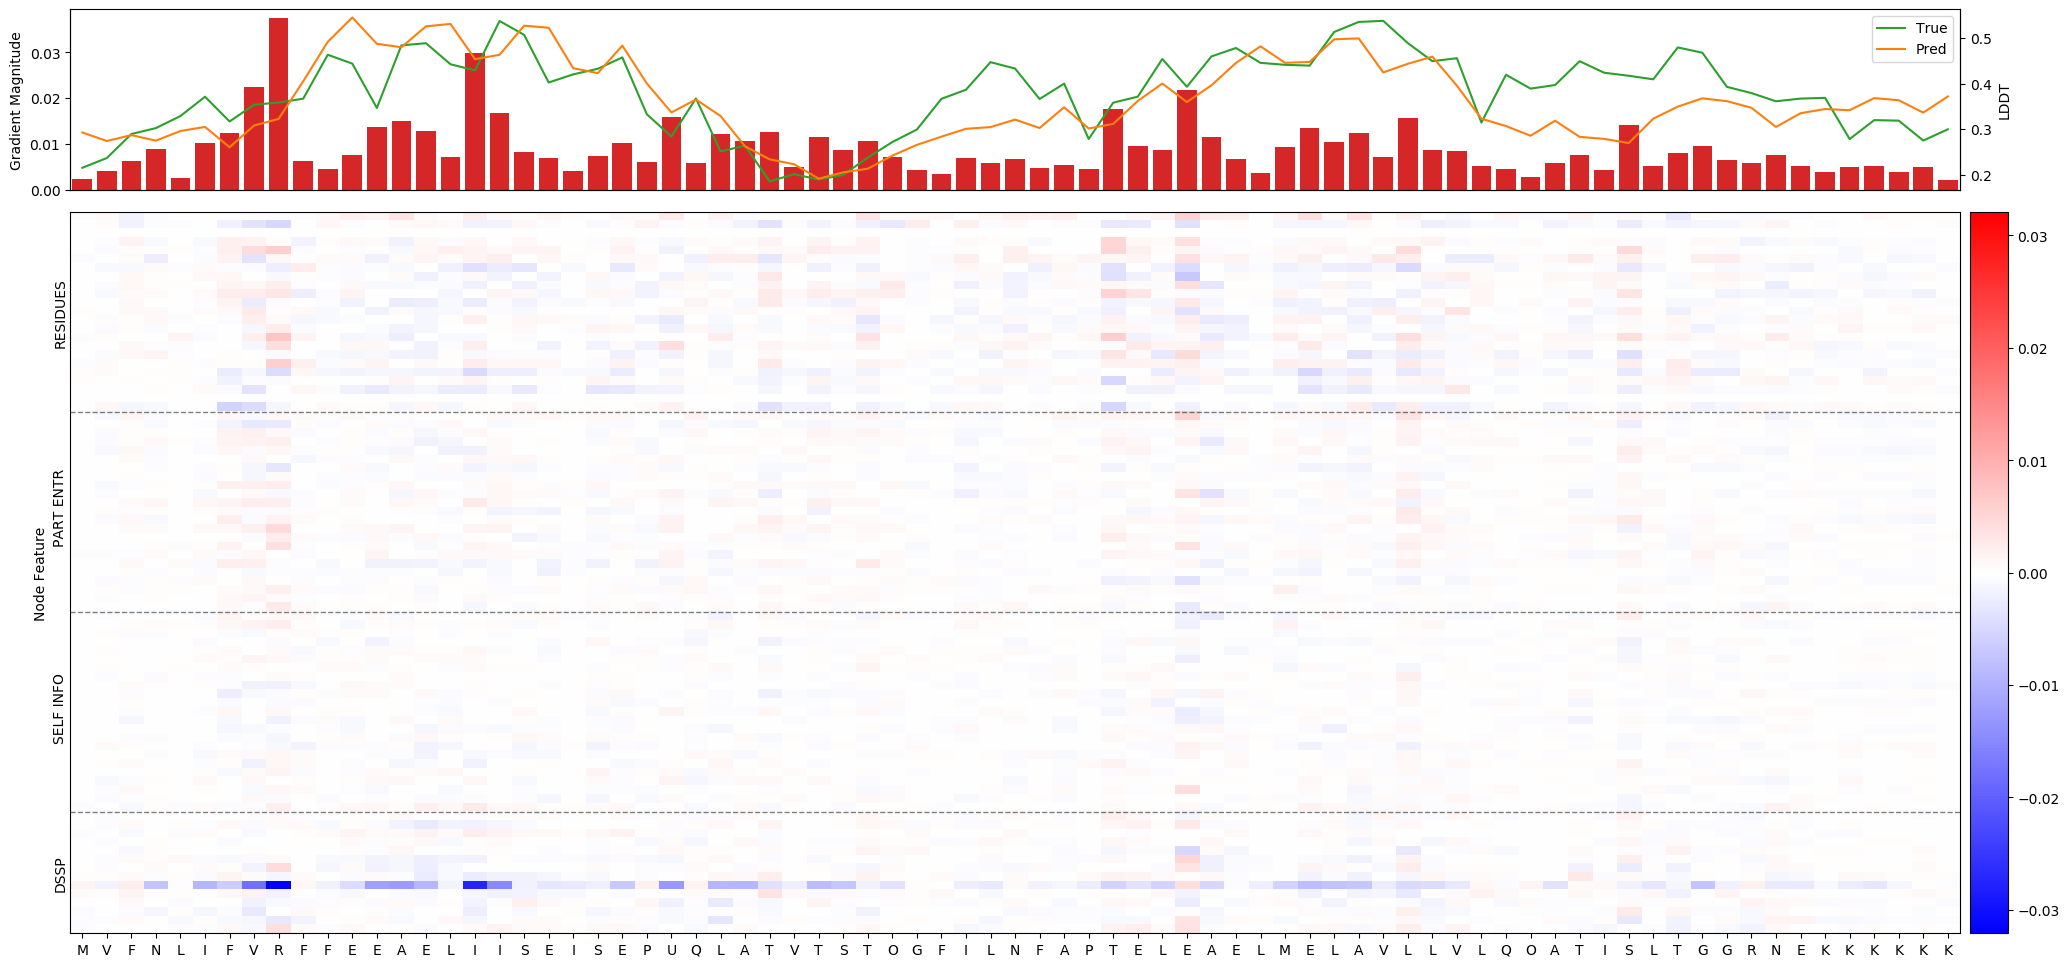

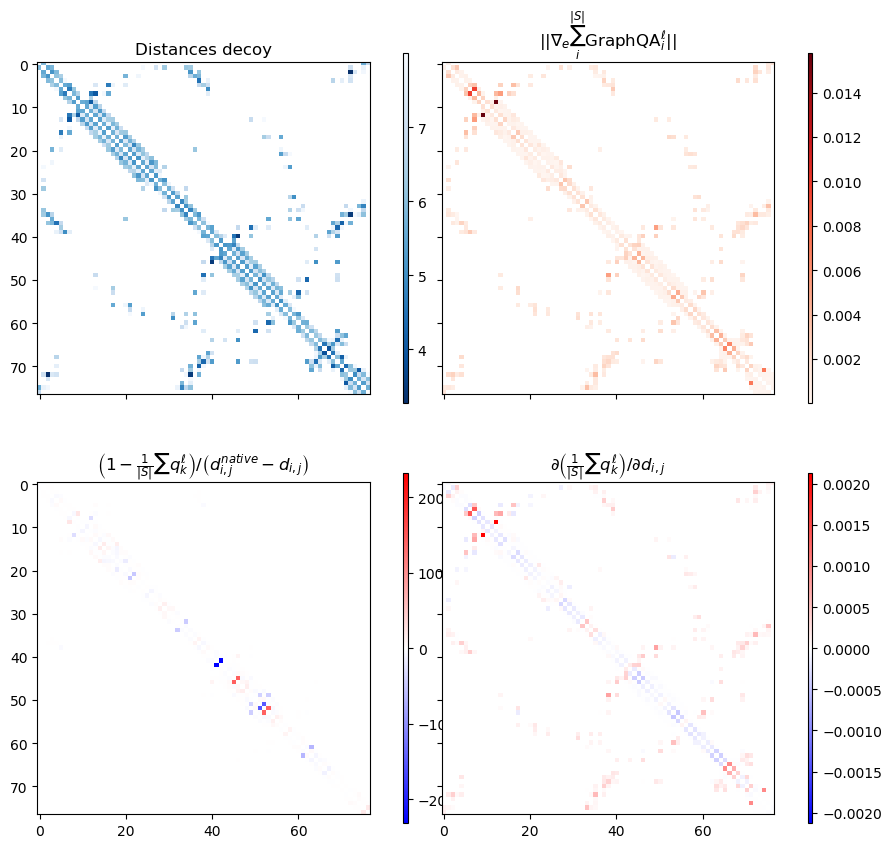

Cosine distance -0.03622343061658784


In [13]:
graph_in.zero_grad_()
graph_pred.node_features.mean().backward(retain_graph=True)
plots_nodes(graph_in, graph_pred, graph_true)
plots_edges(graph_in, graph_pred, graph_native)

On a single residue (the one with the lowest score)

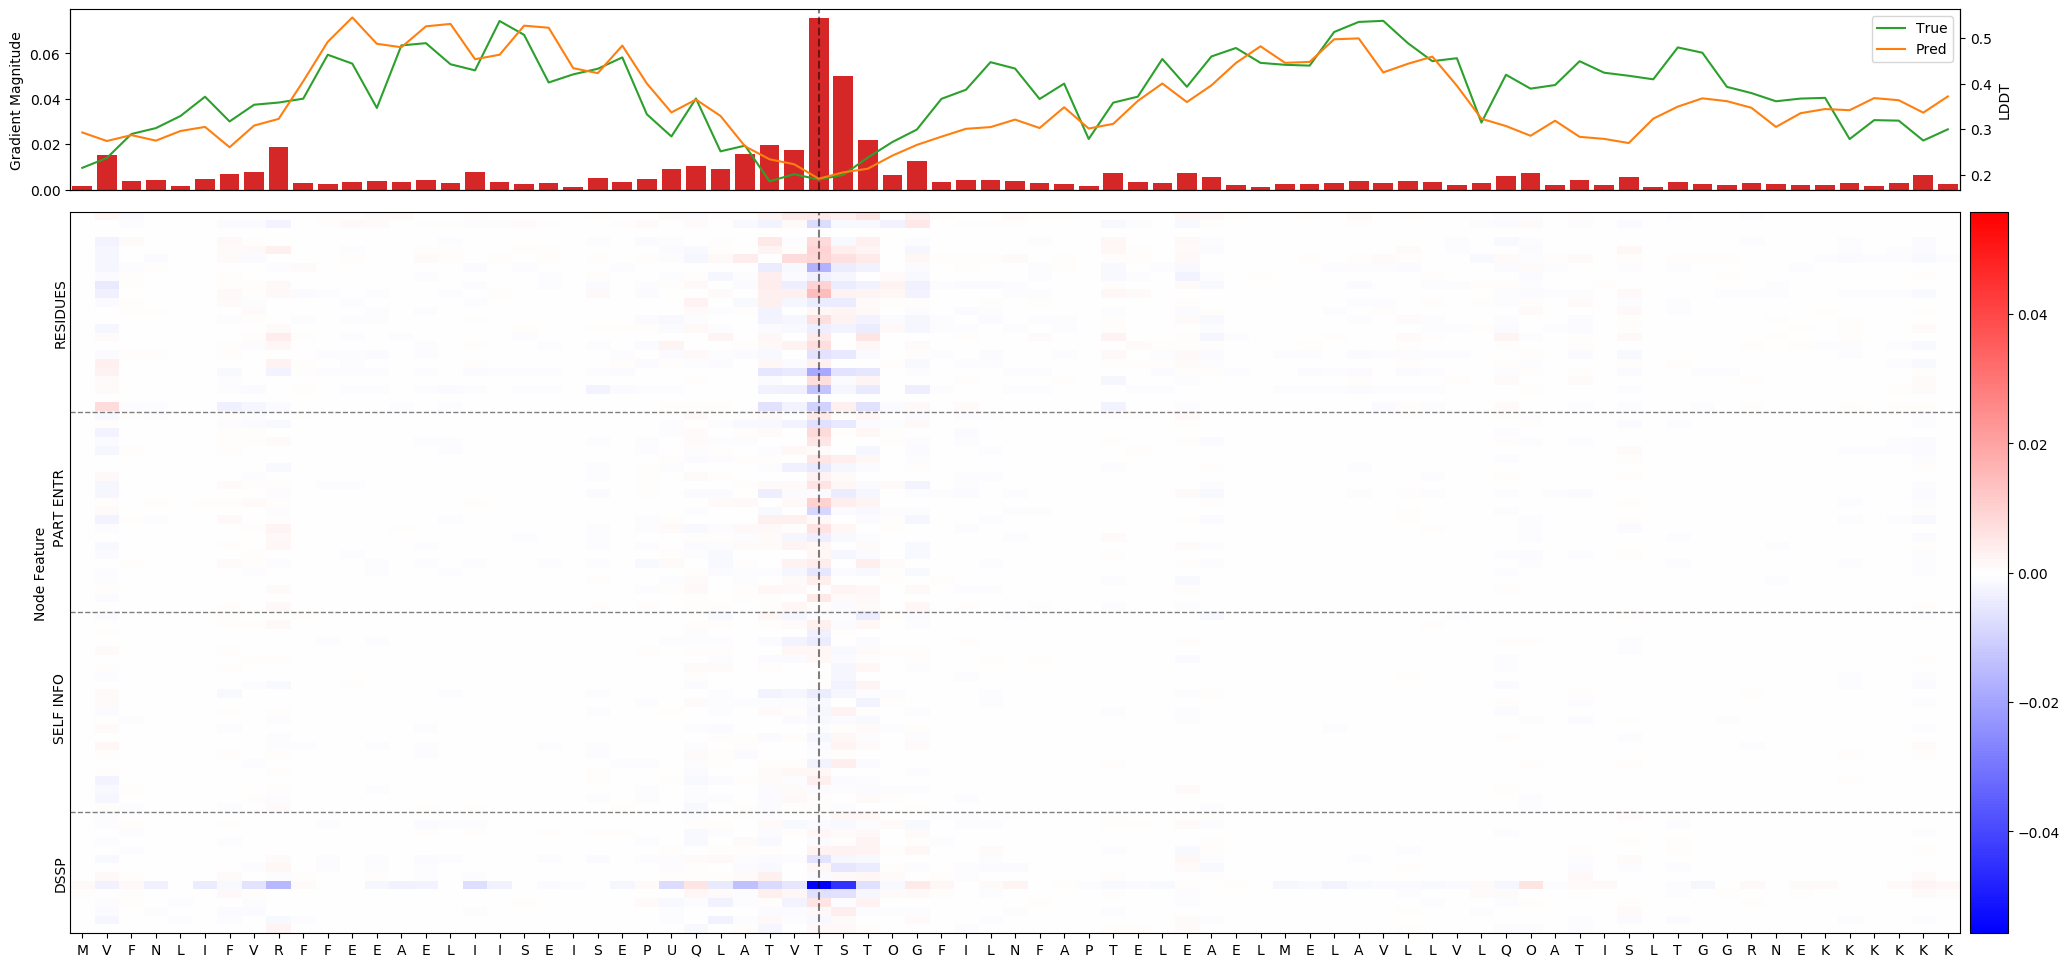

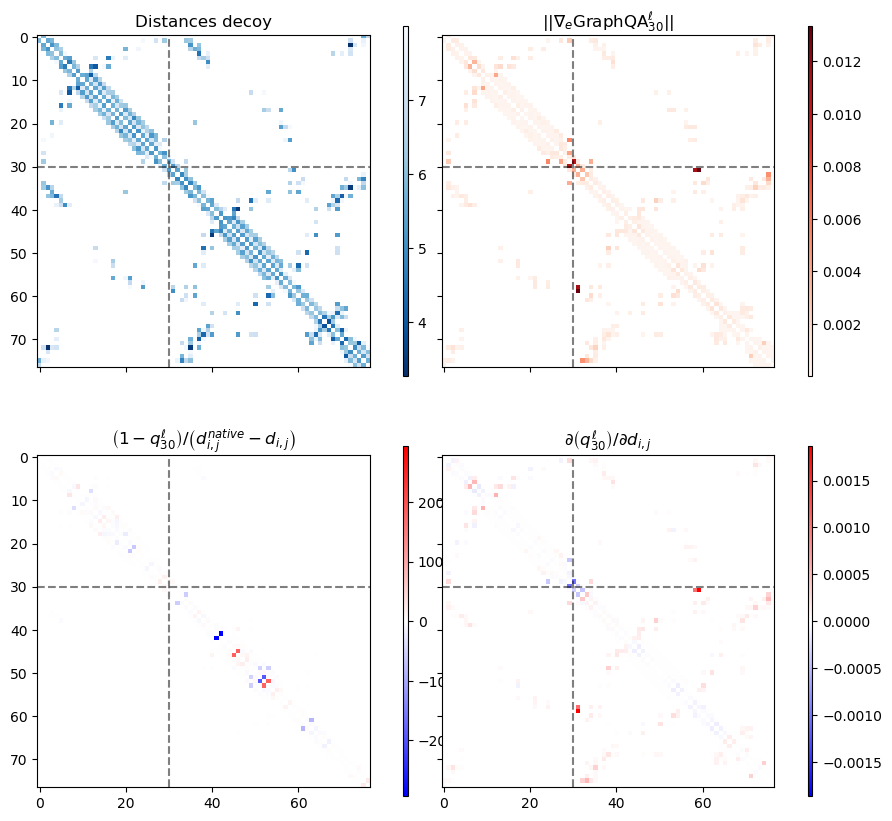

Cosine distance -0.022925914045631268


In [14]:
graph_in.zero_grad_()
graph_pred.node_features.min().backward(retain_graph=True)
plots_nodes(graph_in, graph_pred, graph_true, highlight_residue=graph_pred.node_features.argmin().item())
plots_edges(graph_in, graph_pred, graph_native, highlight_residue=graph_pred.node_features.argmin().item())

On a single residue of choice

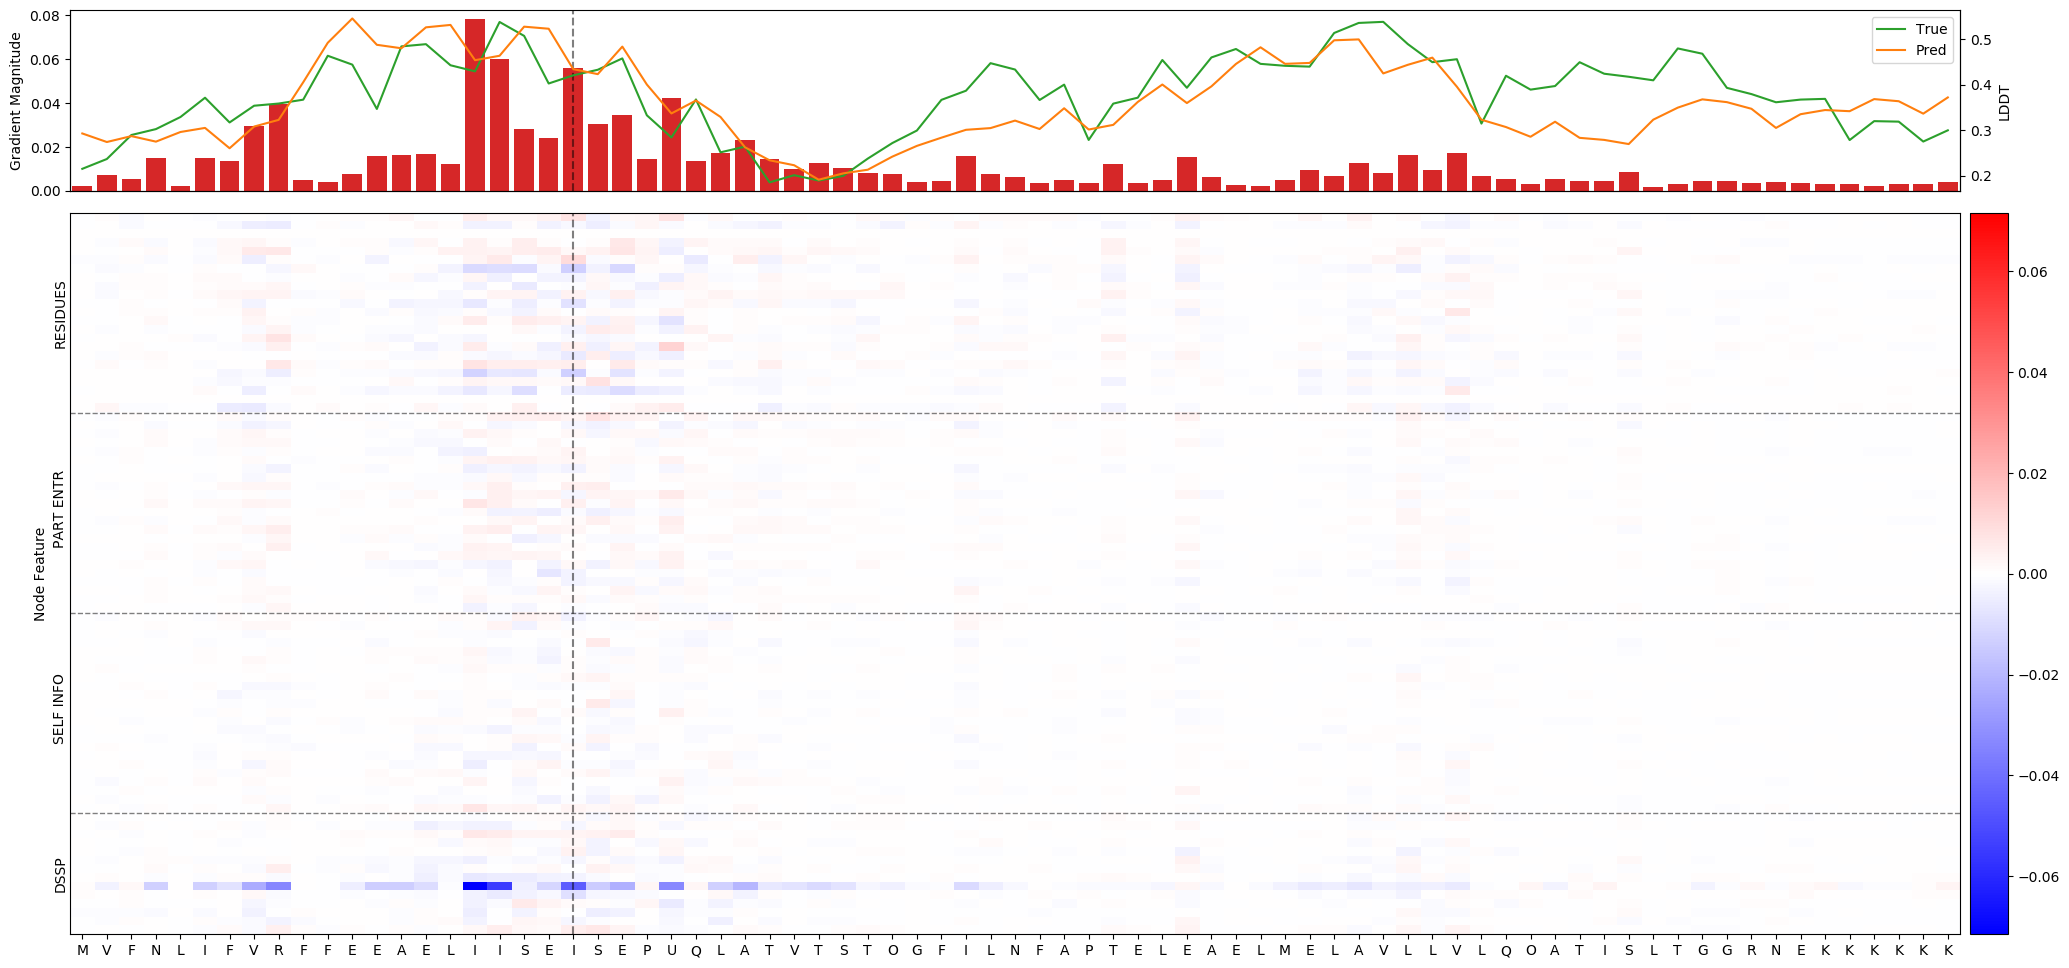

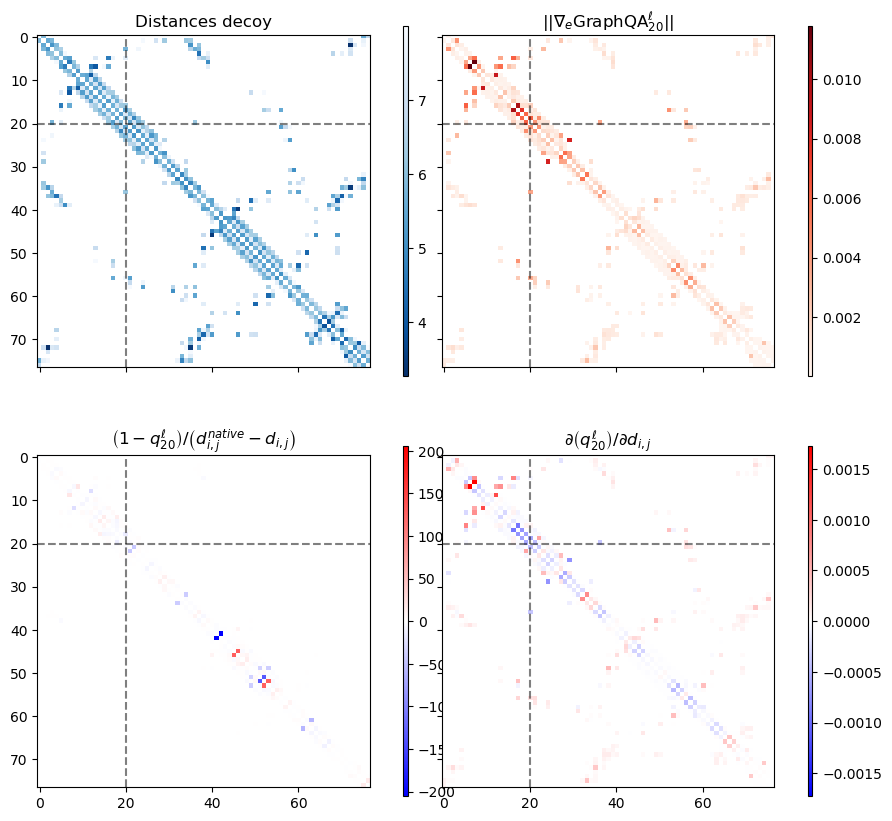

Cosine distance -0.017378902257222828


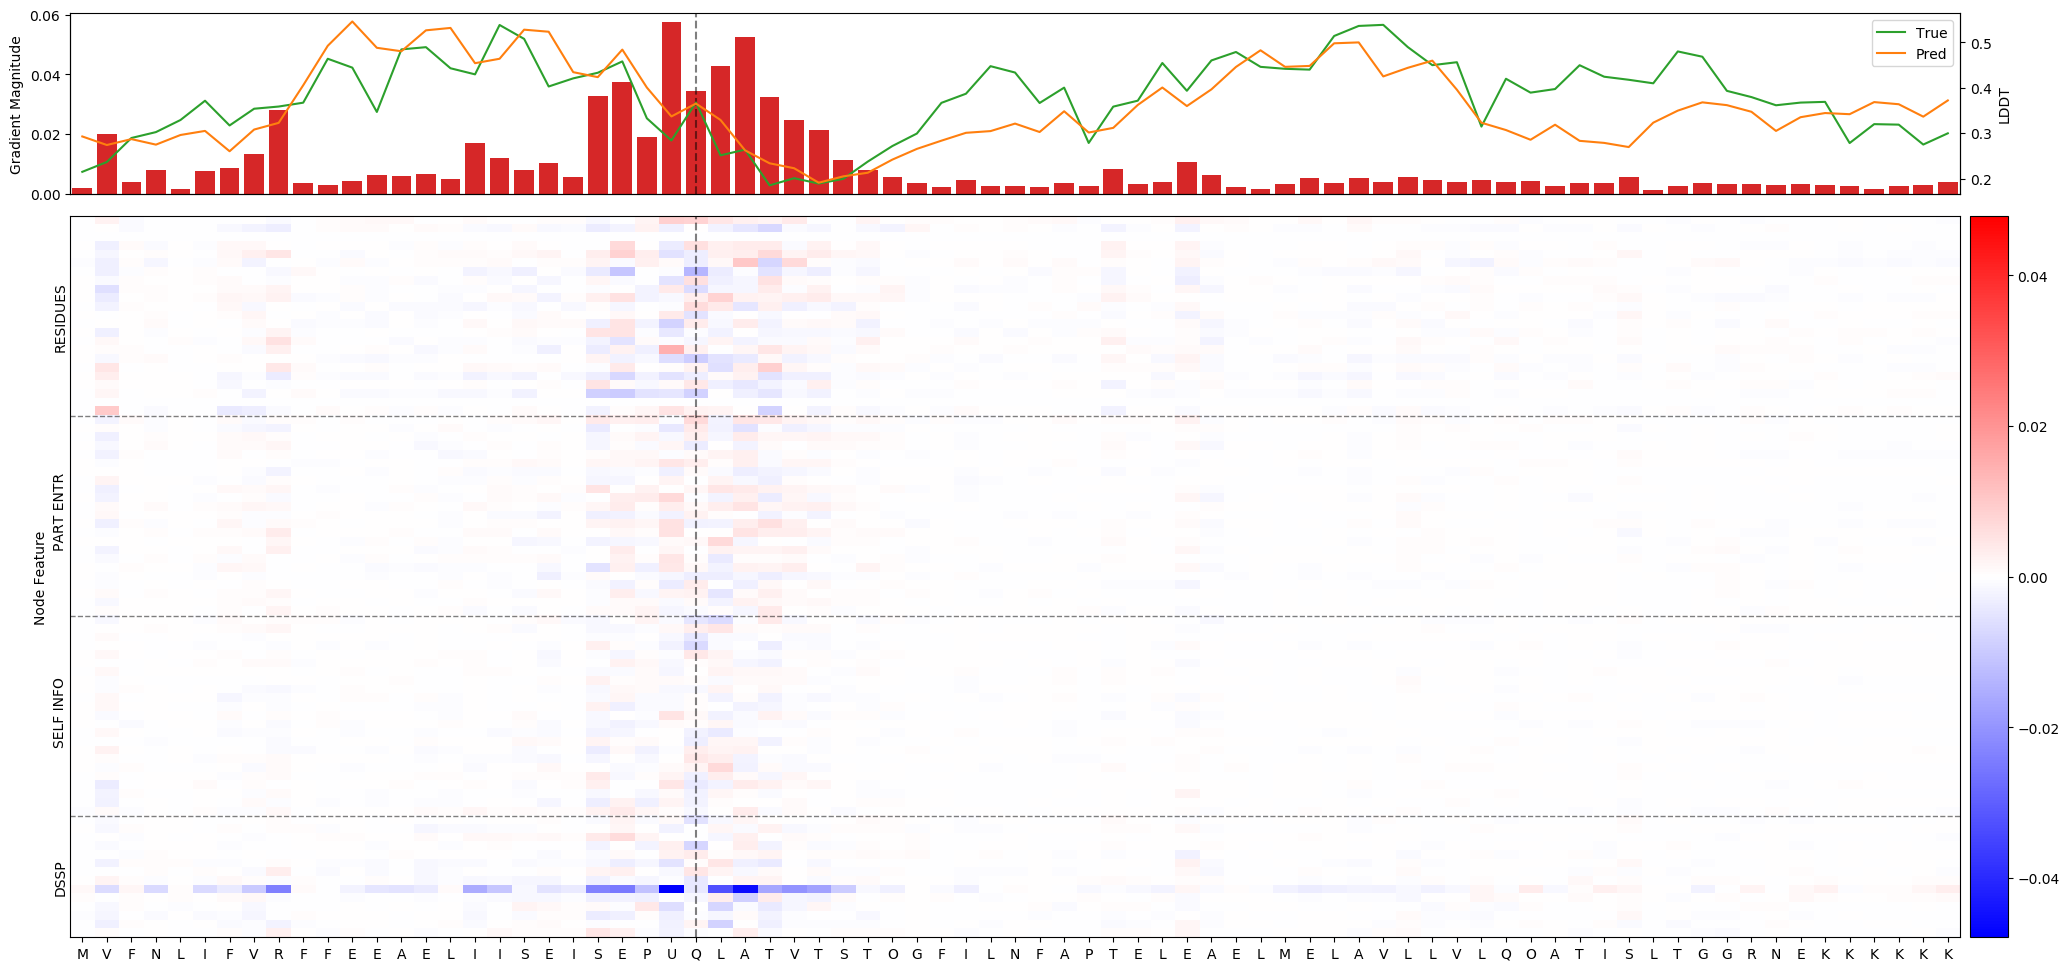

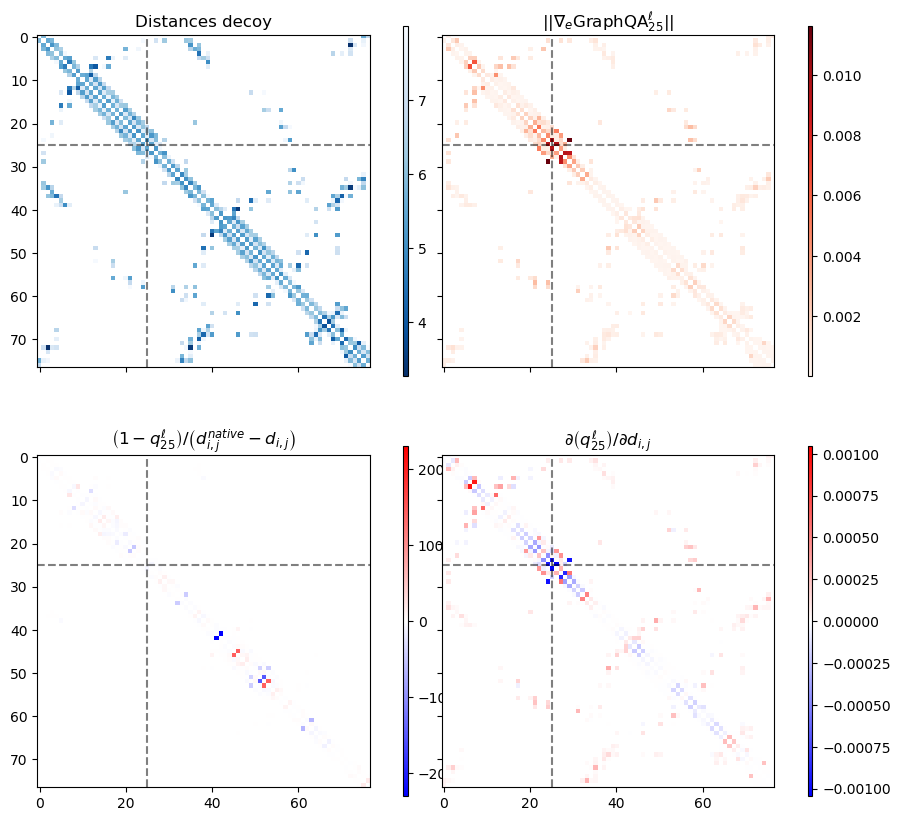

Cosine distance 0.007946919817182763


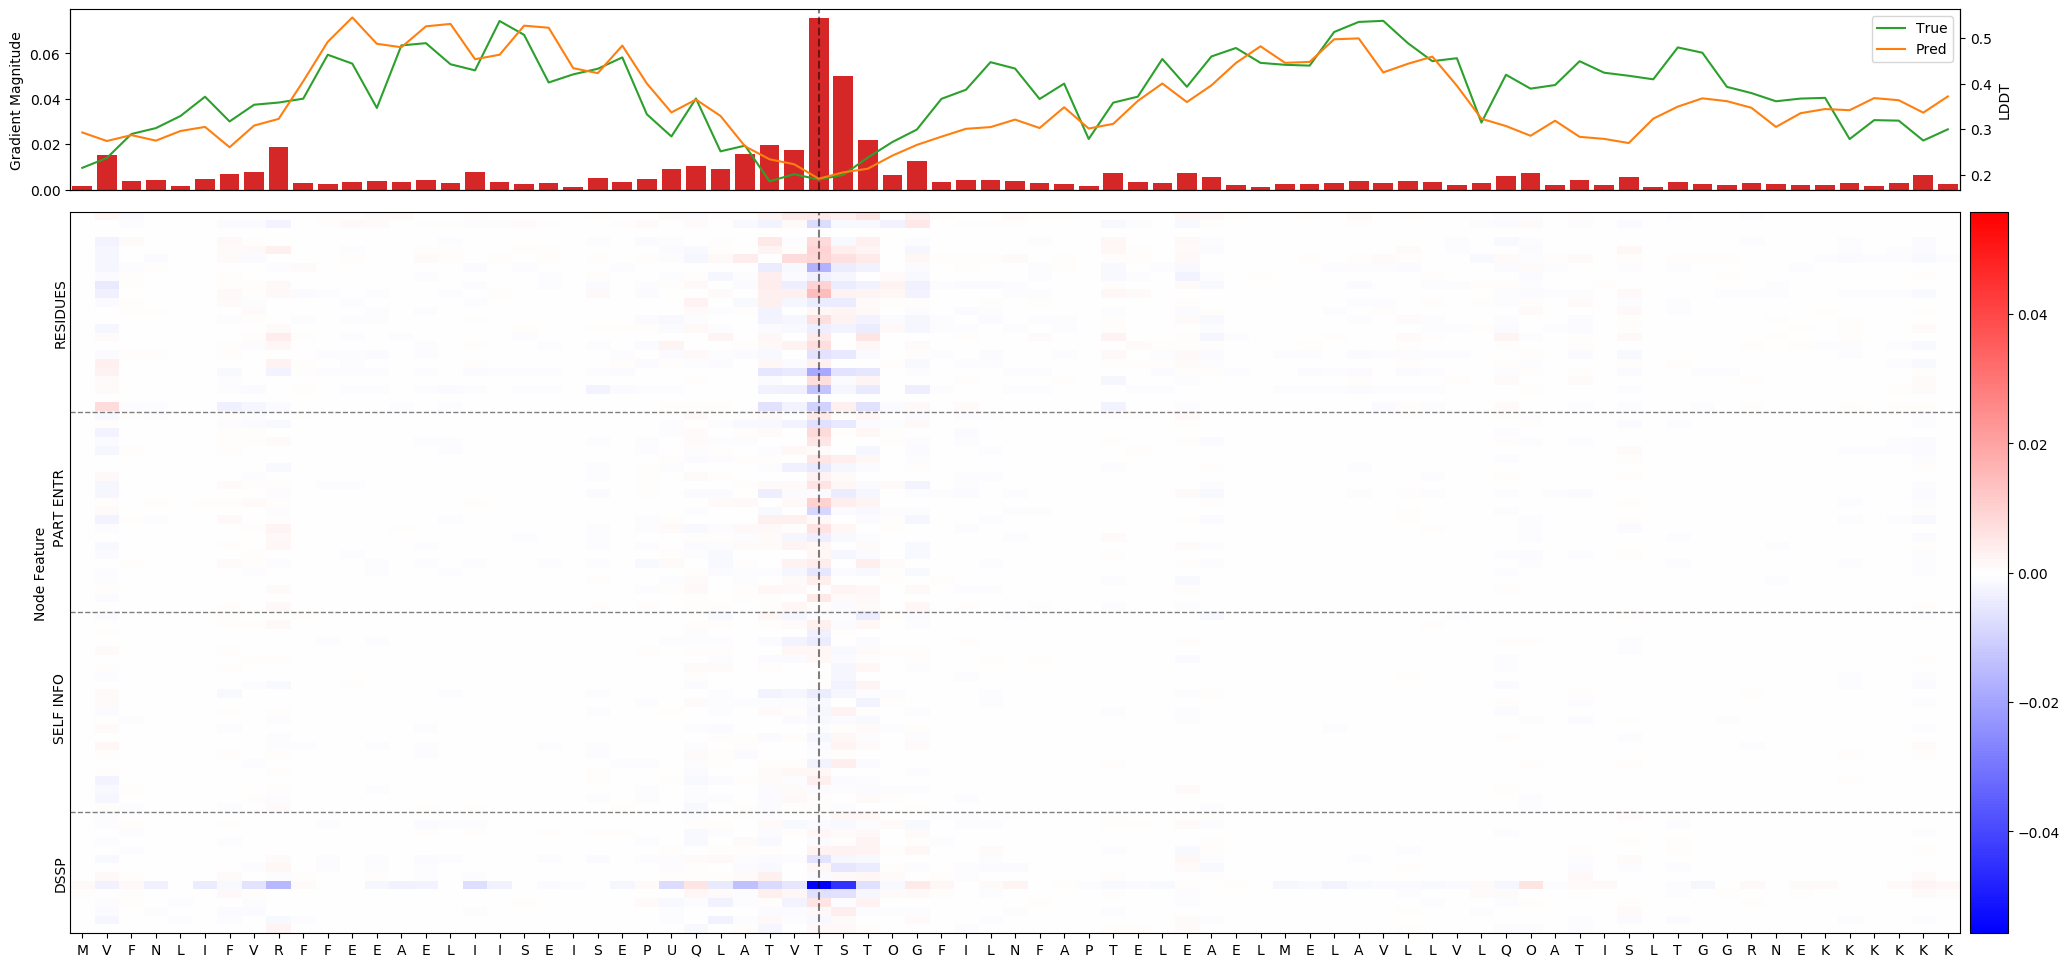

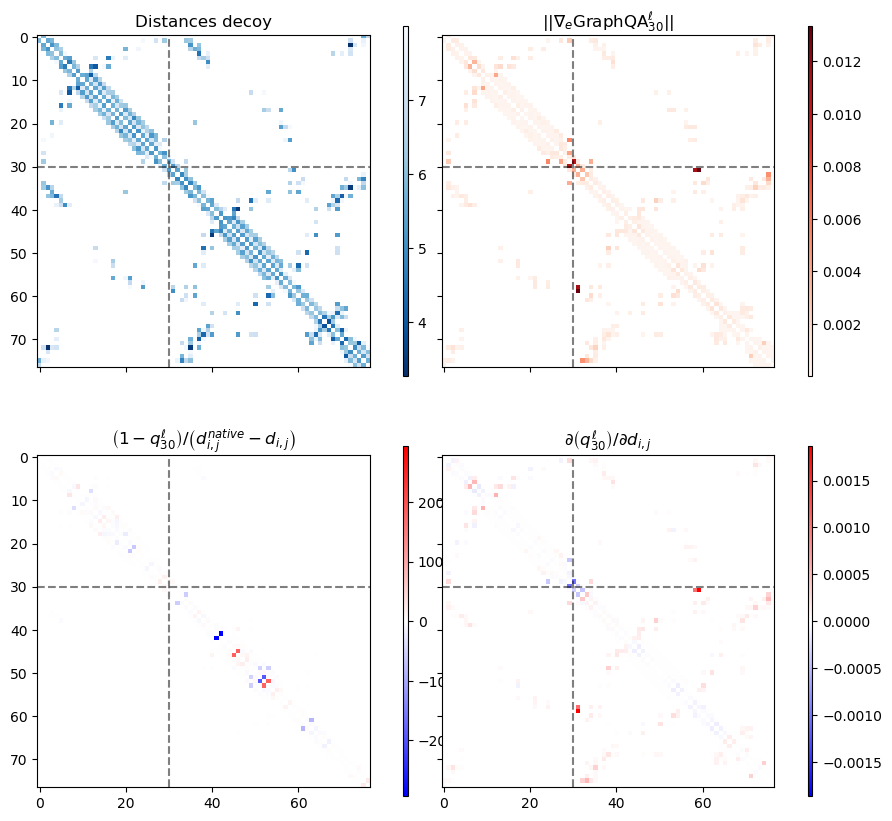

Cosine distance -0.02292591370371344


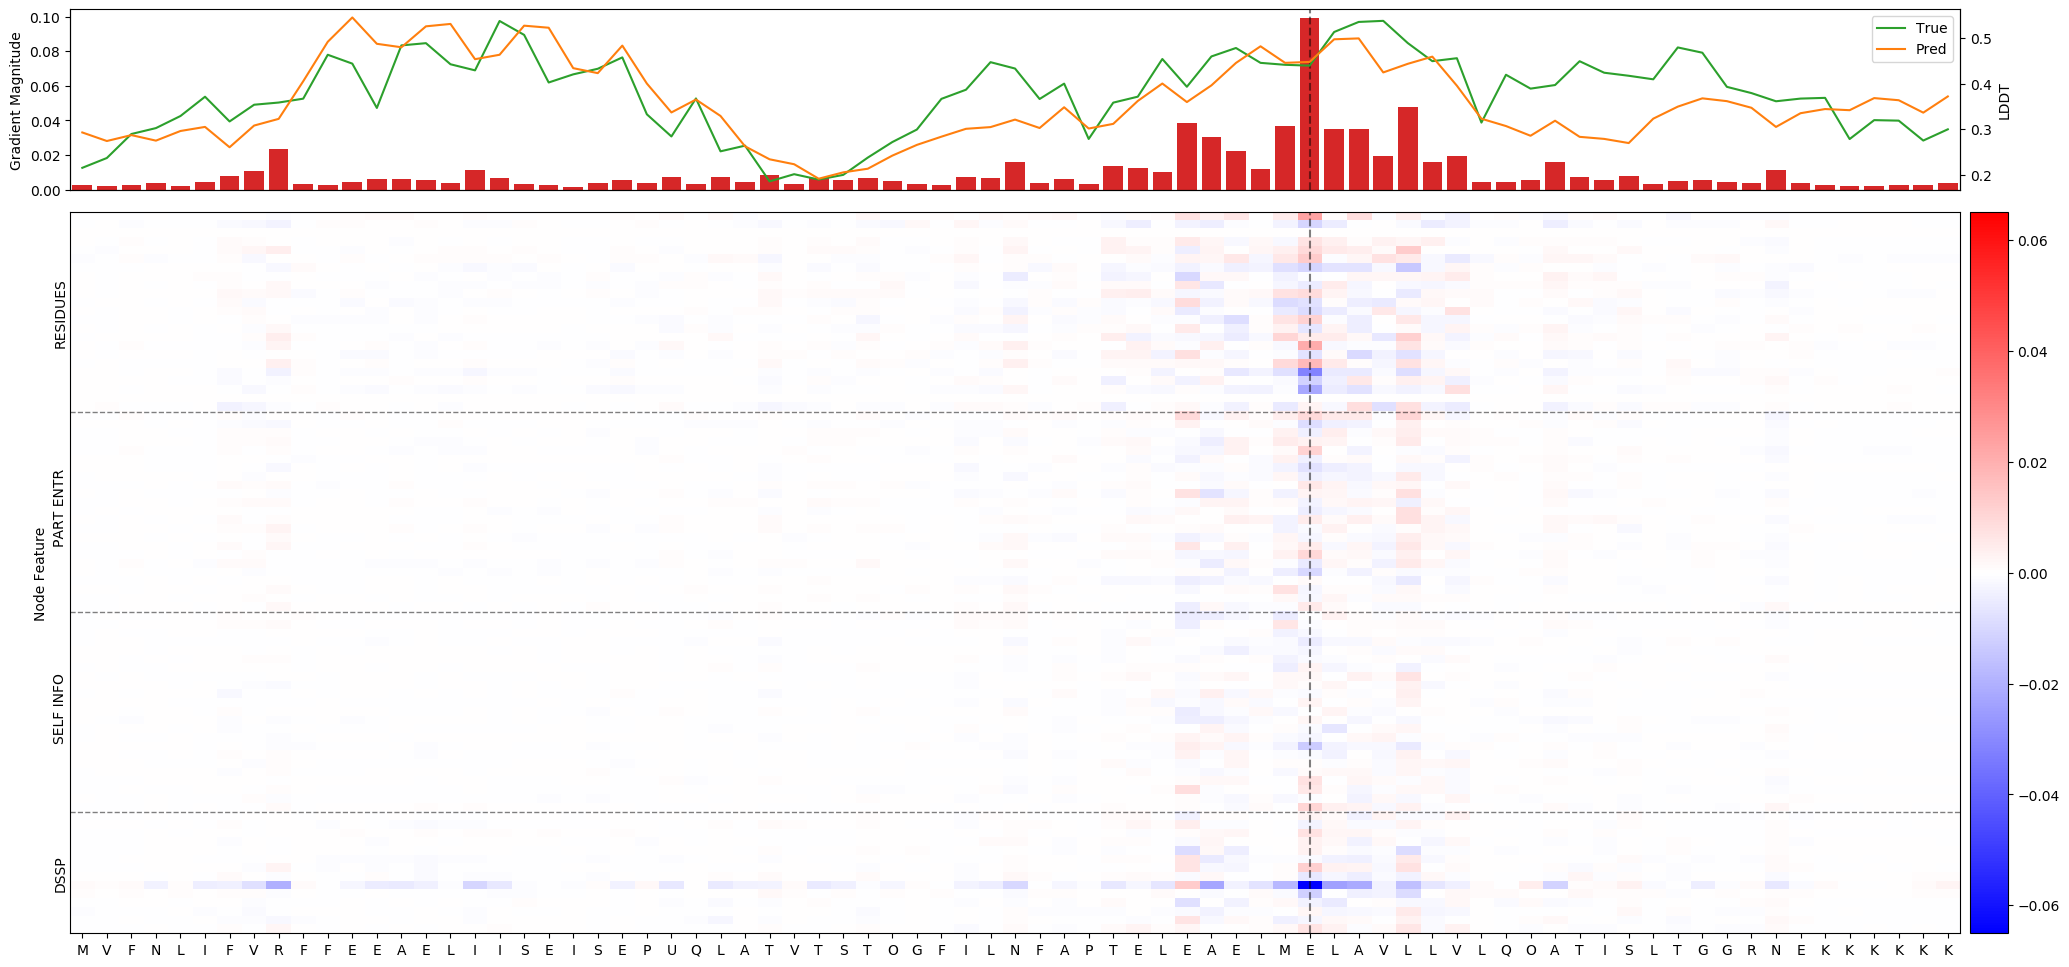

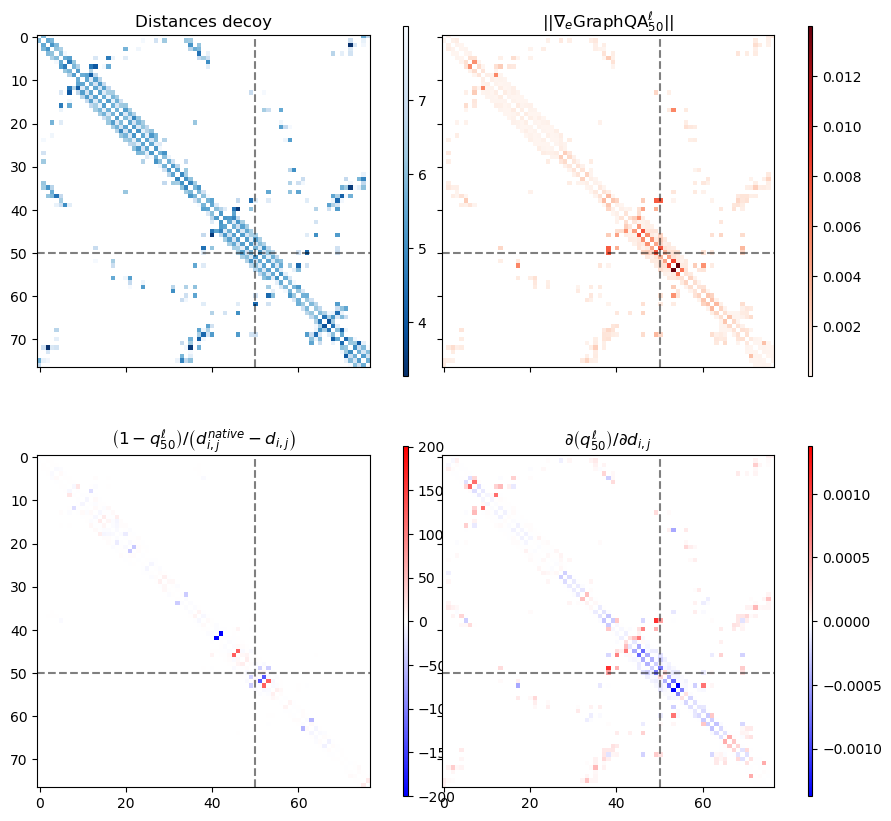

Cosine distance -0.11775033957139258


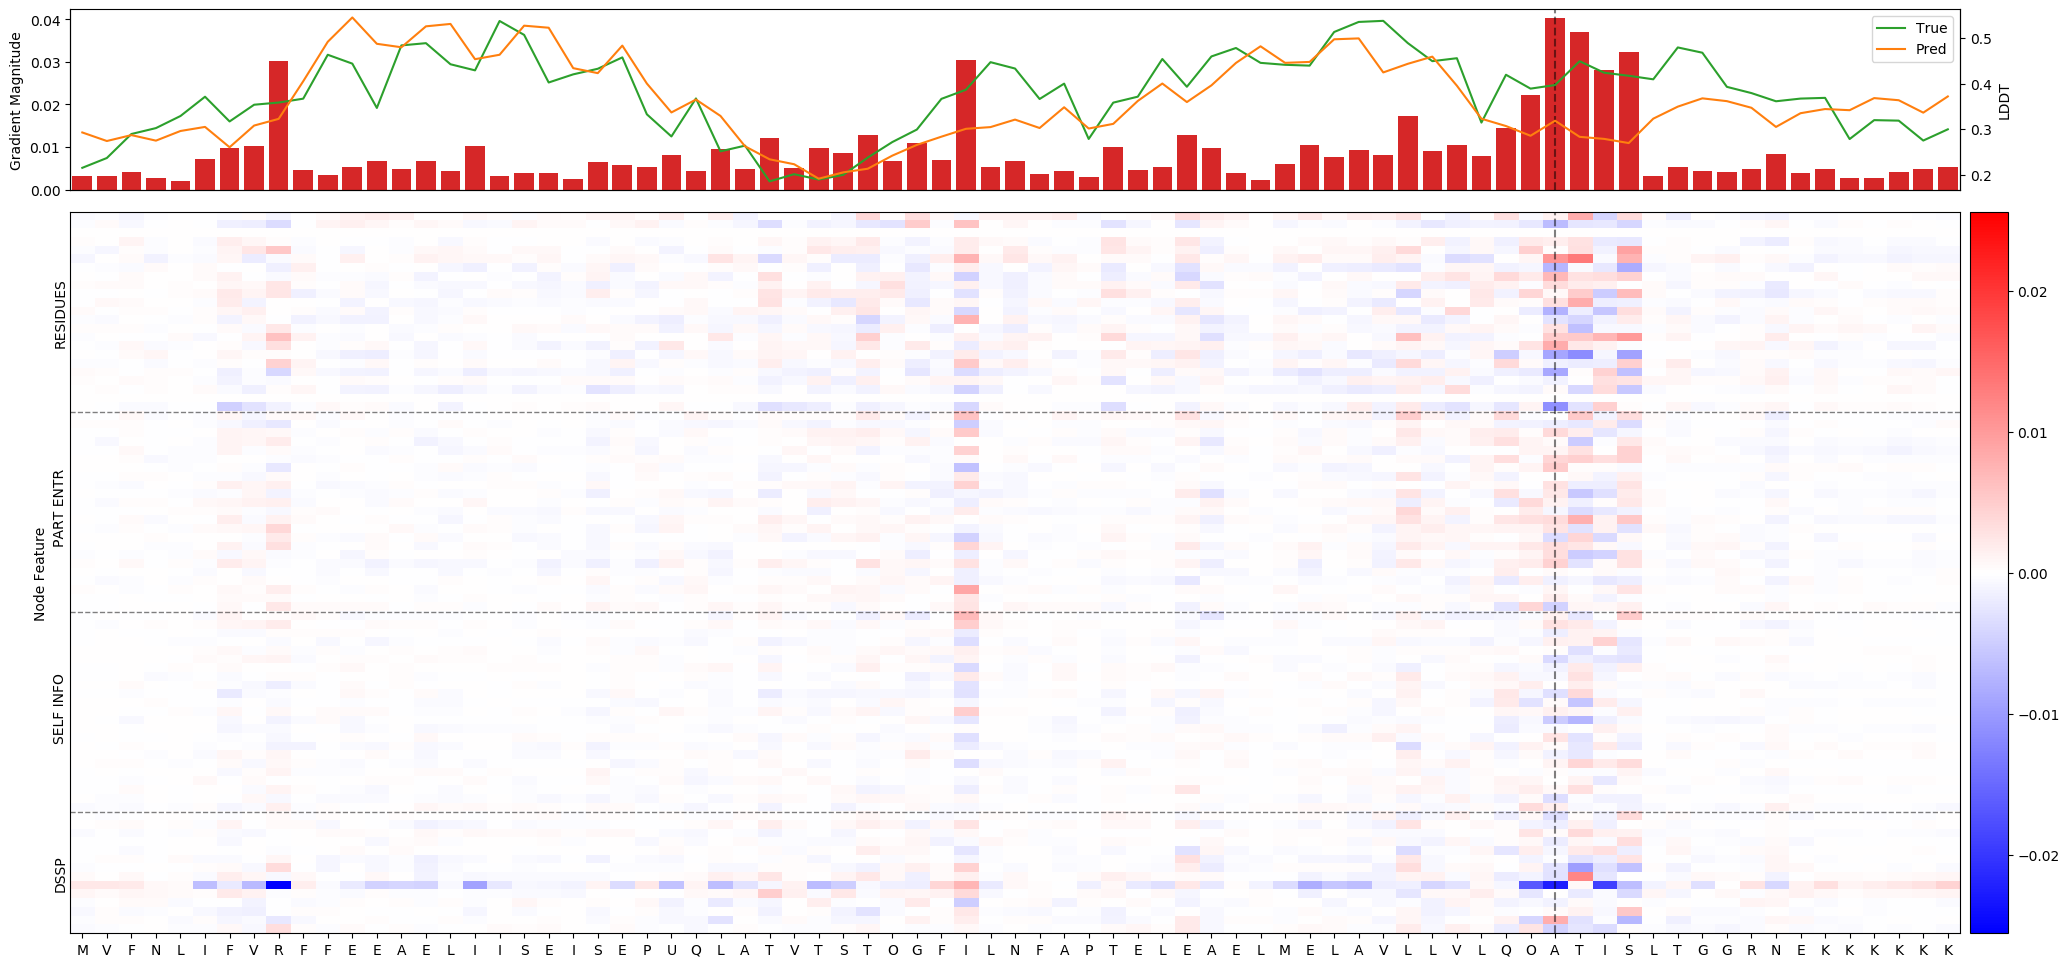

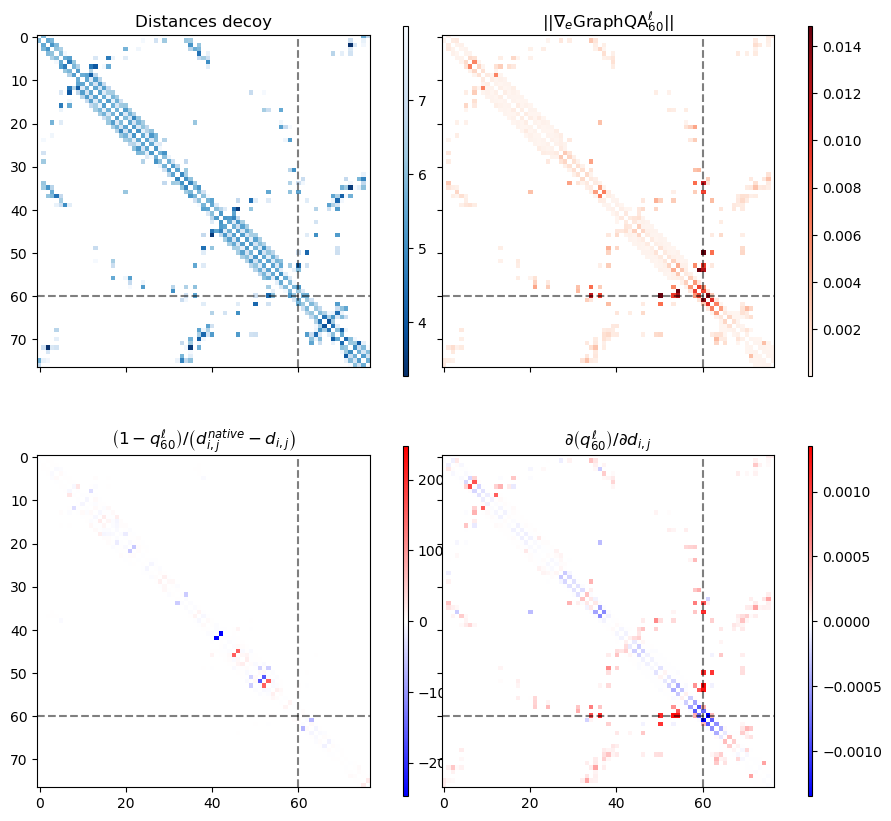

Cosine distance -0.027751892141976375


In [15]:
for highlight_residue in [20, 25, 30, 50, 60]:
    graph_in.zero_grad_()
    graph_pred.node_features[highlight_residue, 0].backward(retain_graph=True)
    plots_nodes(graph_in, graph_pred, graph_true, highlight_residue=highlight_residue)
    plots_edges(graph_in, graph_pred, graph_native, highlight_residue=highlight_residue)

## Intermediate Node Gradients

- Propagate back the gradient from a single node
- See where the gradient goes vs. where the gradient _could_ go following the edges (and ignoring the global path)
- We do it on a longer protein because it's more interesting

In [16]:
casp, target = 'CASP11', 'T0801'

In [17]:
with open(f'../data/{casp}/dataset_stats.yaml') as f:
    max_sequence_length = yaml.safe_load(f)['max_length']

transforms = [
    # Edge features (removing edges should go first)
    proteins.dataset.RemoveEdges(cutoff=cutoff),
    proteins.dataset.RbfDistEdges(sigma=ex['data']['sigma']),
    proteins.dataset.SeparationEncoding(use_separation=ex['data']['separation']),
    
    # Node features (selecting features should go first)
    proteins.dataset.SelectNodeFeatures(ex['data'].get('residues', True), ex['data'].get('partial_entropy', True),
                       ex['data'].get('self_info', True), ex['data'].get('dssp_features', True)),
    proteins.dataset.PositionalEncoding(encoding_size=ex['data']['encoding_size'], base=ex['data']['encoding_base'],
                       max_sequence_length=max_sequence_length)
]

df = pd.read_csv(f'../data/{casp}/samples.csv').query(f'target == "{target}"')
df.path = [f'../data/{casp}/' + p for p in df['path']]
ds = proteins.dataset.ProteinQualityDataset(df, transforms=transforms)

lddt_true_all = []
lddt_pred_all = []
dl = torch.utils.data.DataLoader(ds, batch_size=25, collate_fn=tg.data.GraphBatch.collate)
for _, _, graph_in, graph_true in iter(dl):
    graph_in = graph_in.to(device)
    graph_pred = net(graph_in)
    
    for g in graph_pred:
        lddt_pred_all.append(g.node_features[:, proteins.features.Output.Node.LOCAL_LDDT].detach().cpu().numpy())
    
    for g in graph_true:
        lddt_true_all.append(g.node_features[:, proteins.features.Output.Node.LOCAL_LDDT].detach().cpu().numpy())
        
rmse = np.sqrt(np.nanmean((np.concatenate(lddt_pred_all) - np.concatenate(lddt_true_all)) ** 2))
print(f'{casp}/{target} ({len(df)} decoys, {len(lddt_pred_all[0])} residues): {rmse:.5f} RMSE')

CASP11/T0801 (189 decoys, 376 residues): 0.10721 RMSE


In [18]:
class GradientSaver(object):
    def __init__(self, net=None):
        self.gradients = {}
        
        self._net = net
        self._handles_modules = []
        self._handles_tensors = []
        self._backward_count = None
        
    def _prepare_forward(self, *_):
        self.gradients.clear()
        self._backward_count = 0
        
    def _register_backward_hook(self, module, input_tuple, *, module_name):
        inputs: tg.GraphBatch = input_tuple[0]
        
        backward_hook = functools.partial(self._backward_hook, key=(module_name, 'nodes'))
        backward_hook = functools.update_wrapper(backward_hook, self._backward_hook)
        handle = inputs.node_features.register_hook(backward_hook)
        self._handles_tensors.append(handle)
        
        backward_hook = functools.partial(self._backward_hook, key=(module_name, 'edges'))
        backward_hook = functools.update_wrapper(backward_hook, self._backward_hook)
        handle = inputs.edge_features.register_hook(backward_hook)
        self._handles_tensors.append(handle)
        
        if inputs.global_features is not None:
            backward_hook = functools.partial(self._backward_hook, key=(module_name, 'global'))
            backward_hook = functools.update_wrapper(backward_hook, self._backward_hook)
            handle = inputs.global_features.register_hook(backward_hook)
            self._handles_tensors.append(handle)
            
    def _backward_hook(self, grad, *, key):
        print(f'Saving grad of {key} with shape: \t{tuple(grad.shape)}')
        
        self.gradients[key] = grad
        
        # The last backward hook should cleanup after itself
        self._backward_count += 1
        if self._backward_count == len(self._handles_tensors):
            for handle in self._handles_tensors:
                handle.remove()
            self._handles_tensors.clear()
            self._backward_count = 0
    
    def attach(self, net, prefix='net'):
        handle = net.register_forward_pre_hook(self._prepare_forward)
        self._handles_modules.append(handle)
        
        register_backward_hook = functools.partial(self._register_backward_hook, module_name='encoder')
        register_backward_hook = functools.update_wrapper(register_backward_hook, self._register_backward_hook)
        handle = net.encoder.register_forward_pre_hook(register_backward_hook)
        self._handles_modules.append(handle)
        
        for name, module in net.layers.named_children():
            register_backward_hook = functools.partial(self._register_backward_hook, module_name=name)
            register_backward_hook = functools.update_wrapper(register_backward_hook, self._register_backward_hook)
            handle = module.register_forward_pre_hook(register_backward_hook)
            self._handles_modules.append(handle)
            
        register_backward_hook = functools.partial(self._register_backward_hook, module_name='readout')
        register_backward_hook = functools.update_wrapper(register_backward_hook, self._register_backward_hook)
        handle = net.readout.register_forward_pre_hook(register_backward_hook)
        self._handles_modules.append(handle)

    def detach(self):
        for handle in self._handles_tensors:
            handle.remove()
        self._handles_tensors.clear()
        for handle in self._handles_modules:
            handle.remove()
        self._handles_modules.clear()
        
    def __enter__(self):
        self.attach(self._net)
        return self
        
    def __exit__(self, exception_type, exception_value, traceback):
        self.detach()

In [19]:
_, _, graph_native, _ = ds[0]

_, decoy, graph_in, graph_true = ds[2]
graph_in = tg.data.GraphBatch.from_graphs([graph_in]).cuda()
graph_in.node_features.requires_grad_()
graph_in.edge_features.requires_grad_()
graph_pred = net(graph_in)

rmse = np.sqrt(np.nanmean((graph_pred.node_features[:,0].detach().cpu() - graph_true.node_features[:,0].cpu()) ** 2))

print(f'{casp}/{target}/{decoy}: {rmse:.5f} RMSE')

CASP11/T0801/MUFOLD_Server_TS3: 0.08870 RMSE


Saving grad of ('readout', 'nodes') with shape: 	(376, 64)
Saving grad of ('readout', 'edges') with shape: 	(4072, 16)
Saving grad of ('layer_5', 'global') with shape: 	(1, 64)
Saving grad of ('layer_5', 'nodes') with shape: 	(376, 64)
Saving grad of ('layer_5', 'edges') with shape: 	(4072, 16)
Saving grad of ('layer_4', 'global') with shape: 	(1, 64)
Saving grad of ('layer_4', 'nodes') with shape: 	(376, 128)
Saving grad of ('layer_4', 'edges') with shape: 	(4072, 32)
Saving grad of ('layer_3', 'global') with shape: 	(1, 128)
Saving grad of ('layer_3', 'nodes') with shape: 	(376, 256)
Saving grad of ('layer_3', 'edges') with shape: 	(4072, 64)
Saving grad of ('layer_2', 'global') with shape: 	(1, 256)
Saving grad of ('layer_2', 'nodes') with shape: 	(376, 256)
Saving grad of ('layer_2', 'edges') with shape: 	(4072, 64)
Saving grad of ('layer_1', 'global') with shape: 	(1, 256)
Saving grad of ('layer_1', 'nodes') with shape: 	(376, 256)
Saving grad of ('layer_1', 'edges') with shape: 	

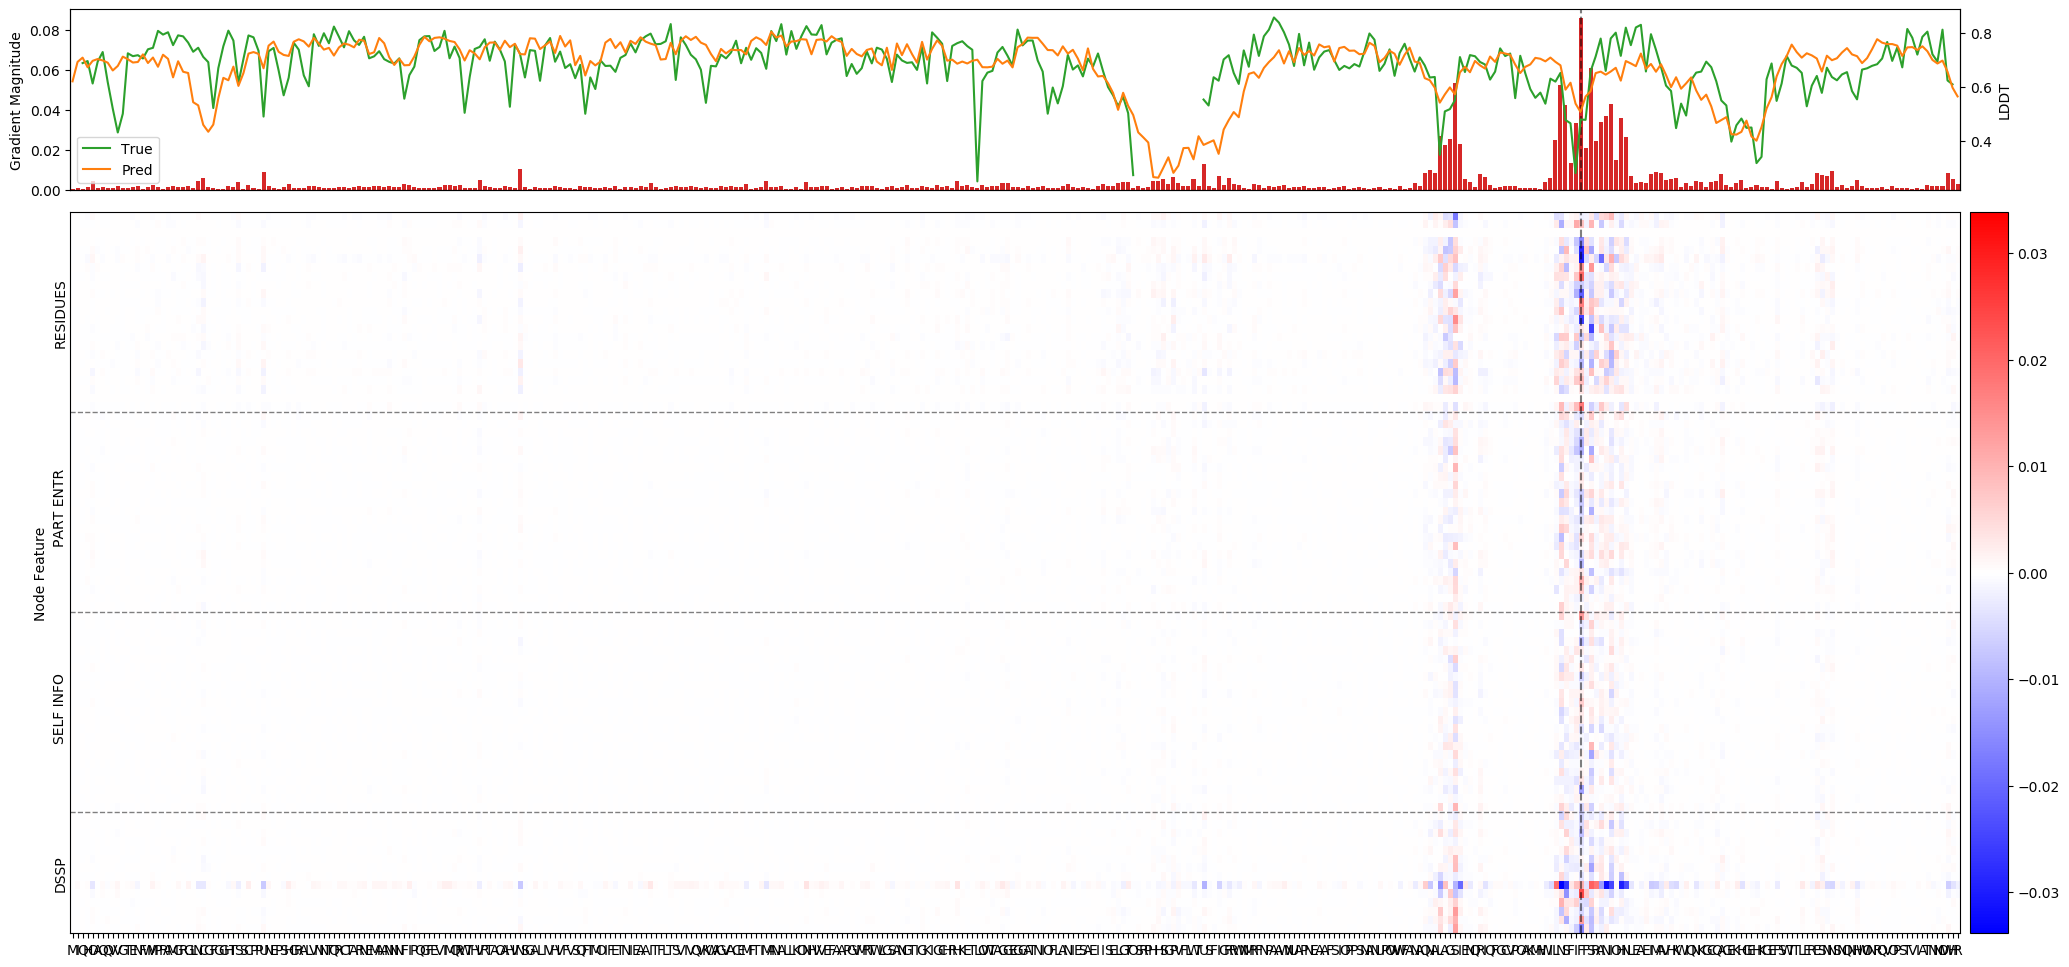

In [20]:
graph_in.zero_grad_()
with GradientSaver(net) as saver:
    graph_pred = net(graph_in)
    graph_pred.node_features[300, 0].backward(torch.tensor(1., device=device))
    
plots_nodes(graph_in, graph_pred, graph_true, highlight_residue=300)

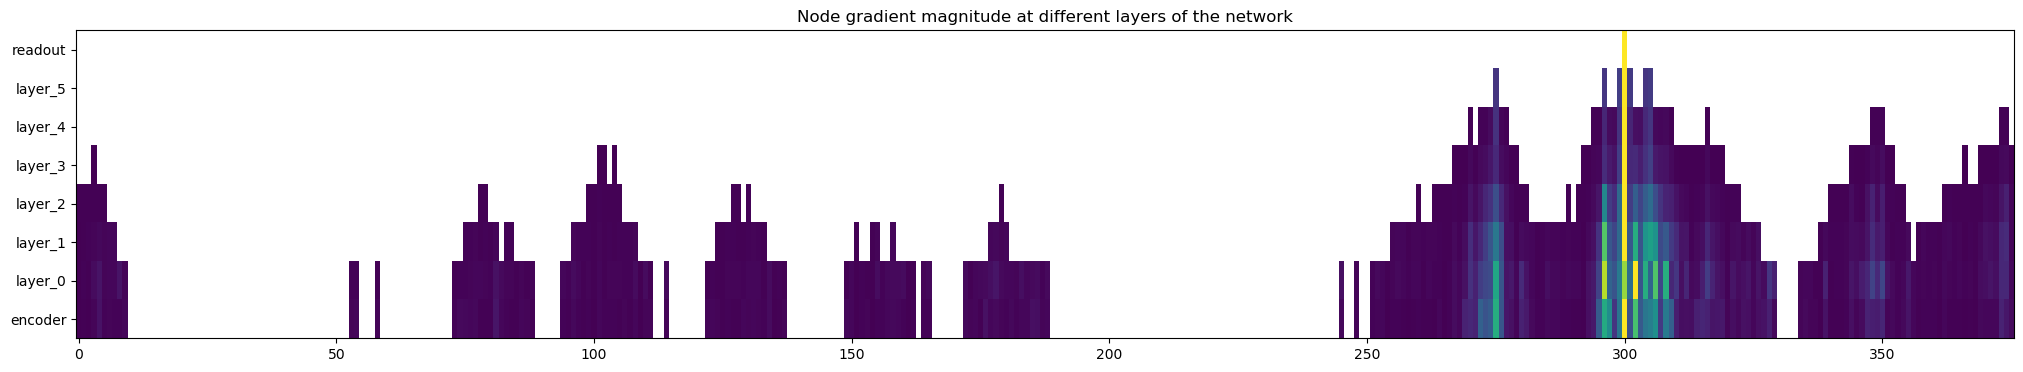

In [21]:
# How gradients propagate
node_gradients = {k: grad.norm(dim=1).cpu() for k, grad in saver.gradients.items() if k[1] == 'nodes'}
node_gradients_img = torch.stack(tuple(node_gradients.values()), dim=0)
node_gradients_img = node_gradients_img / node_gradients_img.max(dim=1, keepdim=True)[0]

# Where gradients could actually propagate following the edges
node_gradients_mask = torch.zeros_like(node_gradients_img)
node_gradients_mask[0] = node_gradients_img[0]
for layer_idx in range(0, len(node_gradients_img) - 2):
    node_gradients_mask[layer_idx + 1] = node_gradients_mask[layer_idx]
    for s,r in zip(graph_in.senders, graph_in.receivers):
        node_gradients_mask[layer_idx + 1, s] += node_gradients_mask[layer_idx, r]
        
node_gradients_mask[-1] = node_gradients_mask[-2]
node_gradients_mask = node_gradients_mask > 0
node_gradients_img = torch.where(node_gradients_mask, node_gradients_img, torch.tensor(np.nan))

fig, ax = plt.subplots(1, 1, figsize=(25, 4))

im = ax.imshow(node_gradients_img, aspect='auto')
ax.set_yticks(np.arange(len(node_gradients)))
ax.set_yticklabels([k[0] for k in node_gradients.keys()]);
ax.set_title('Node gradient magnitude at different layers of the network')

display(fig)
plt.close(fig);

del graph_in, graph_pred, graph_true, node_gradients, node_gradients_img, node_gradients_mask

## Are edge distance gradients informative?

We assume that our network $f$ has learned the $\text{GDT_TS}$ scoring function.

The most basic thing to compare is that for a given decoy $C$, is that $f^g(C)$ and $\text{GDT_TS}(C)$ are as close as possible, i.e. we compute $\text{MSE}$

But also we want $f(C)$ to be informative, i.e. $f'(C)$ should point in the direction of increasing $\text{GDT_TS}(C)$, with particular focus on the contacts.

So we compute the cosine similarity between the contact error and the contact gradient, to see how collinear they are:

$$\cos\left( d^{\text{native}}_{i,j} - d_{i,j} ;\quad \frac{\partial f^g}{\partial\, d_{i,j}} (C) \right)$$

Also, we compute the agreement between the signs of the contact error and the contact gradient, as a percentage.

Compute: 
- cosine distance
- sign agreement

Between:
- true error (distance_native - distance_decoy)
- distance gradient as computed by the network

In [22]:
def cos(x, y):
    valid = np.isfinite(x) & np.isfinite(y)
    return 1 - scipy.spatial.distance.cosine(x[valid], y[valid])

def signs(x, y):
    valid = np.isfinite(x) & np.isfinite(y)
    return np.count_nonzero(np.sign(x[valid]) == np.sign(y[valid])) / np.count_nonzero(valid)

In [23]:
_, _, graph_native, _ = ds[0]
_, decoy, graph_decoy, graph_true = ds[2]

graph_decoy = tg.data.GraphBatch.from_graphs([graph_decoy]).to(device)
graph_decoy.edge_features.requires_grad_()
graph_pred = net(graph_decoy)

rmse_local = np.sqrt(np.nanmean((graph_pred.node_features[:,0].detach().cpu() - graph_true.node_features[:,0].cpu()) ** 2))
rmse_global = np.sqrt((graph_pred.global_features[0, 1].item() - graph_true.global_features[1].item()) ** 2)
print(f'{casp}/{target}/{decoy}: RMSE local {rmse_local:.5f} RMSE global {rmse_global:.5f}')

graph_decoy.zero_grad_()
graph_pred.global_features[0, proteins.features.Output.Global.GLOBAL_GDTTS].backward()

distance_native = dist_dense(graph_native, ex['data']['sigma'])
distance_decoy = dist_dense(graph_decoy, ex['data']['sigma'])
distance_delta = (distance_native - distance_decoy)
distance_grad = grad_dist_dense(graph_decoy, ex['data']['sigma'])

print(f'''Is finite: 
- native {np.count_nonzero(np.isfinite(distance_native))}/{distance_native.size}
- decoy {np.count_nonzero(np.isfinite(distance_decoy))}/{distance_decoy.size}
- delta {np.count_nonzero(np.isfinite(distance_delta))}/{distance_delta.size}
- grad {np.count_nonzero(np.isfinite(distance_grad))}/{distance_grad.size}
''')

print(f'Cosine: {cos(distance_grad, distance_delta):.3f}')
print(f'Signs: {signs(distance_grad, distance_delta):.2%}')

CASP11/T0801/MUFOLD_Server_TS3: RMSE local 0.08870 RMSE global 0.03671
Is finite: 
- native 3938/141376
- decoy 4072/141376
- delta 3478/141376
- grad 4072/141376

Cosine: 0.133
Signs: 51.35%


In [24]:
# Load the whole dataset
casp = 'CASP11'

with open(f'../data/{casp}/dataset_stats.yaml') as f:
    max_sequence_length = yaml.safe_load(f)['max_length']

transforms = [
    # Edge features (removing edges should go first)
    proteins.dataset.RemoveEdges(cutoff=ex['data']['cutoff']),
    proteins.dataset.RbfDistEdges(sigma=ex['data']['sigma']),
    proteins.dataset.SeparationEncoding(use_separation=ex['data']['separation']),
    
    # Node features (selecting features should go first)
    proteins.dataset.SelectNodeFeatures(ex['data'].get('residues', True), ex['data'].get('partial_entropy', True),
                       ex['data'].get('self_info', True), ex['data'].get('dssp_features', True)),
    proteins.dataset.PositionalEncoding(encoding_size=ex['data']['encoding_size'], base=ex['data']['encoding_base'],
                       max_sequence_length=max_sequence_length)
]

df = pd.read_csv(f'../data/{casp}/samples.csv')
df.path = [f'../data/{casp}/' + p for p in df['path']]

In [25]:
MAX_TARGETS = 100
MAX_DECOYS_PER_TARGET = 250

# df_local = defaultdict(list)
df_global = defaultdict(list)

for target in tqdm.tqdm(df.target.unique()[:MAX_TARGETS]):
    ds = proteins.dataset.ProteinQualityDataset(df.query(f'target == "{target}"'), transforms=transforms)
    
    _, _, g_native, g_native_true = ds[0]
    distance_native = dist_dense(g_native, ex['data']['sigma'])
    lddt_native = g_native_true.node_features[:, 0].numpy()
    gdtts_native = g_native_true.global_features[1].item()

    for decoy_idx in np.random.permutation(np.arange(1, len(ds)))[:MAX_DECOYS_PER_TARGET]:
        _, _, g_decoy, g_decoy_true = ds[decoy_idx]
        # lddt_decoy = g_decoy_true.node_features[:, 0].numpy()
        gdtts_decoy = g_decoy_true.global_features[1].item()
        distance_decoy = dist_dense(g_decoy, ex['data']['sigma'])
        distance_delta = distance_native - distance_decoy
        
        g_decoy = tg.data.GraphBatch.from_graphs([g_decoy]).to(device)
        g_decoy.edge_features.requires_grad_()
        g_pred = net(g_decoy)
        
        # Compute gradients for GDT_TS
        g_decoy.zero_grad_()
        g_pred.global_features[0, 1].backward(retain_graph=True)
        grad_net_global = grad_dist_dense(g_decoy, ex['data']['sigma'])
        df_global['cosine'].append(cos(grad_net_global, distance_delta))
        df_global['signs'].append(signs(grad_net_global, distance_delta))
        
        # Compute gradients for LDDT, residue by residue
        # for res_index in range(g_decoy.num_nodes):
        #     if np.isnan(lddt_native[res_index]) or np.isnan(lddt_decoy[res_index]):
        #         continue
        #     g_decoy.zero_grad_()
        #     g_pred.node_features[res_index, 0].backward(retain_graph=True)
        #     grad_net_local = grad_dist_dense(g_decoy, ex['data']['sigma'])
        #     grad_lddt = (lddt_native[res_index] - lddt_decoy[res_index]) / (distance_delta)
        #     df_local['cosine'].append(cos(grad_net_local, grad_lddt))
        #     df_local['cosine_delta_grad'].append(cos(grad_net_local, distance_delta))
        #     df_local['signs'].append(signs(grad_net_local, grad_lddt))

#df_local = pd.DataFrame(df_local)
df_global = pd.DataFrame(df_global)

100%|██████████| 85/85 [24:27<00:00, 19.19s/it]


In [26]:
# display(df_local.describe())
display(df_global.describe())

,cosine,signs
count,16009.000000,16009.000000
mean,0.140010,0.528578
std,0.083067,0.032063
min,-0.238204,0.408228
25%,0.084235,0.508221
50%,0.128282,0.525701
75%,0.183667,0.546012
max,0.599547,0.760331


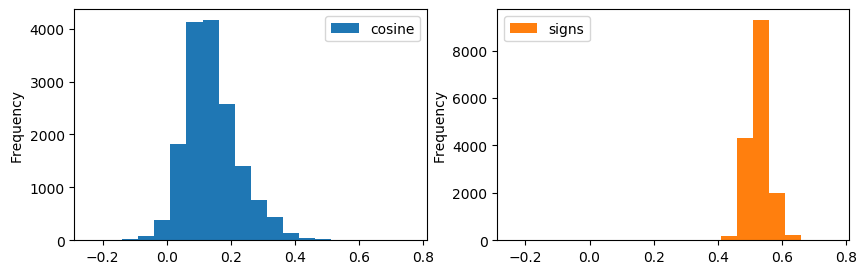

In [27]:
ax = df_global.plot.hist(subplots=True, bins=20, layout=(1,2), figsize=(10,3))
display(ax[0,0].figure)